
# ESG-aware Portfolio Optimisation

This notebook shows **different ways** to incorporate ESG data *directly* into portfolio optimisation (rather than pre-filtering the investable universe), using **Riskfolio-Lib** where practical and a **cvxpy** fallback for linear constraints:

1. **Minimum weighted-average ESG score** (linear constraint).  
5. **Group caps / best-in-class** using ESG quantile groupings.  
7. **ESG-driven clustering** (e.g., hierarchical) with **cluster caps** to ensure diversification across ESG profiles.

Data: prices and sustainability metrics are retrieved from **Yahoo Finance** via `yfinance`.

> **Notes**  
> - Riskfolio-Lib will be used for statistics and plotting.  
> - For linear constraints (min ESG, group caps) we provide a **robust cvxpy solver** so the notebook works even if your Riskfolio version doesn't expose a direct constraint API.  
> - Long-only, fully-invested portfolios in all examples.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

import yfinance as yf

# Riskfolio for stats/plots; optimisation done via either Riskfolio or cvxpy fallback
import riskfolio as rp

# Fallback convex optimisation for linear constraints
import cvxpy as cp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120

# Helper to keep prints concise
def h1(msg):
    print("\n" + "="*len(msg) + f"\n{msg}\n" + "="*len(msg))




## 1) Inputs and Data Download

- Define `assets`, `start`, and `end`.  
- Download prices with `yfinance` and compute daily returns.  
- Retrieve ESG/sustainability metrics (best-effort across common Yahoo fields).


In [2]:
# If you already have `assets`, `start`, `end` in your session, the cell will reuse them.
# Otherwise, let's provide defaults for demonstration.
if 'assets' not in globals():
    assets = ['DELL', 'ABNB', 'PANW', 'BKNG', 'UBER', 'IBM', 'SCCO', 'ADBE', 'JPM', 'XOM', 'PFE',
          'NFLX', 'SAP', 'TXN', 'ORCL', 'TTD', 'MU', 'PYPL', 'INTC',
          'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META', 'TSLA', 'AAPL', 'AMD', 'CRM',
          'V', 'MA', 'AXP', 'BRK-B', 'BAC', 'GS', 'M', 'UNH', 'LLY', 'NVO', 'MRK', 'JNJ', 'COST', 'WMT', 'PG', 'PEP', 'CAT', 'GE' , 'LMT', 'CVX', 'COP', 'NEE' , 'LIN' ,  'AVGO'   ]
    print("Using example tickers:", assets)

if 'start' not in globals():
    start = '2018-01-01'
if 'end' not in globals():
    end = None  # to today

print("Period:", start, "->", end)

Using example tickers: ['DELL', 'ABNB', 'PANW', 'BKNG', 'UBER', 'IBM', 'SCCO', 'ADBE', 'JPM', 'XOM', 'PFE', 'NFLX', 'SAP', 'TXN', 'ORCL', 'TTD', 'MU', 'PYPL', 'INTC', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META', 'TSLA', 'AAPL', 'AMD', 'CRM', 'V', 'MA', 'AXP', 'BRK-B', 'BAC', 'GS', 'M', 'UNH', 'LLY', 'NVO', 'MRK', 'JNJ', 'COST', 'WMT', 'PG', 'PEP', 'CAT', 'GE', 'LMT', 'CVX', 'COP', 'NEE', 'LIN', 'AVGO']
Period: 2018-01-01 -> None


In [3]:
# Download financial data from YahooFinance
p = yf.download(assets, start=start, end=end, group_by='ticker', auto_adjust=False, progress=True)

# Extract Adj Close robustly across versions
def extract_adj_close(p, tickers):
    cols = {}
    frames = []
    for t in tickers:
        try:
            # group_by='ticker' returns per-ticker columns
            s = p[t]['Adj Close'].rename(t)
        except Exception:
            # older/newer yfinance may return multiindex with ('Adj Close', t)
            s = p['Adj Close'][t].rename(t)
        frames.append(s)
    out = pd.concat(frames, axis=1).sort_index()
    return out

adj = extract_adj_close(p, assets)
Y = adj.pct_change().dropna(how='all')

h1("Downloaded prices")
display(adj.tail())
h1("Downloaded returns")
display(Y.tail())

[*********************100%***********************]  52 of 52 completed


Downloaded prices


DELL        ABNB        PANW         BKNG       UBER  \
Date                                                                     
2025-09-29  133.899994  122.919998  203.960007  5454.810059  99.570000   
2025-09-30  141.770004  121.419998  203.619995  5399.270020  97.970001   
2025-10-01  149.679993  122.320000  206.800003  5350.560059  96.610001   
2025-10-02  147.369995  121.489998  209.300003  5424.549805  96.610001   
2025-10-03  140.740005  120.220001  207.190002  5418.049805  96.599998   

                   IBM        SCCO        ADBE         JPM         XOM  ...  \
Date                                                                    ...   
2025-09-29  279.799988  121.089996  359.420013  315.690002  114.220001  ...   
2025-09-30  282.160004  121.360001  352.750000  315.429993  112.750000  ...   
2025-10-01  286.489990  122.639999  343.720001  310.709991  111.989998  ...   
2025-10-02  286.720001  125.320000  351.480011  307.549988  111.290001  ...   
2025-10-03  288.369995  128.289993  346.739990  310.029999  113.260002  ...   

                    PG         PEP         CAT          GE         LMT  \
Date                                                                     
2025-09-29  153.529999  140.169998  471.609985  293.630005  491.980011   
2025-09-30  153.649994  140.440002  477.149994  300.820007  499.209991   
2025-10-01  153.179993  143.139999  480.820007  300.880005  499.000000   
2025-10-02  152.050003  142.309998  490.570007  299.450012  499.359985   
2025-10-03  152.270004  141.979996  497.850006  297.000000  504.489990   

                   CVX        COP        NEE         LIN        AVGO  
Date                                                                  
2025-09-29  156.100006  95.849998  76.209999  476.489990  327.899994  
2025-09-30  155.289993  94.589996  75.489998  475.000000  329.910004  
2025-10-01  154.580002  95.459999  78.669998  466.809998  333.390015  
2025-10-02  153.369995  93.379997  78.180000  469.480011  338.179993  
2025-10-03  153.550003  94.160004  80.059998  466.730011  338.369995  

[5 rows x 52 columns]


Downloaded returns


DELL      ABNB      PANW      BKNG      UBER       IBM  \
Date                                                                     
2025-09-29  0.024013 -0.006306  0.007857 -0.016797  0.011376 -0.015863   
2025-09-30  0.058775 -0.012203 -0.001667 -0.010182 -0.016069  0.008435   
2025-10-01  0.055795  0.007412  0.015617 -0.009022 -0.013882  0.015346   
2025-10-02 -0.015433 -0.006785  0.012089  0.013828  0.000000  0.000803   
2025-10-03 -0.044989 -0.010454 -0.010081 -0.001198 -0.000104  0.005755   

                SCCO      ADBE       JPM       XOM  ...        PG       PEP  \
Date                                                ...                       
2025-09-29  0.034957 -0.002636 -0.001171 -0.025593  ...  0.006754 -0.001923   
2025-09-30  0.002230 -0.018558 -0.000824 -0.012870  ...  0.000782  0.001926   
2025-10-01  0.010547 -0.025599 -0.014964 -0.006741  ... -0.003059  0.019225   
2025-10-02  0.021853  0.022577 -0.010170 -0.006251  ... -0.007377 -0.005799   
2025-10-03  0.023699 -0.013486  0.008064  0.017702  ...  0.001447 -0.002319   

                 CAT        GE       LMT       CVX       COP       NEE  \
Date                                                                     
2025-09-29  0.012560 -0.003360  0.009314 -0.025350 -0.026706  0.004746   
2025-09-30  0.011747  0.024487  0.014696 -0.005189 -0.013146 -0.009448   
2025-10-01  0.007692  0.000199 -0.000421 -0.004572  0.009198  0.042125   
2025-10-02  0.020278 -0.004753  0.000721 -0.007828 -0.021789 -0.006229   
2025-10-03  0.014840 -0.008182  0.010273  0.001174  0.008353  0.024047   

                 LIN      AVGO  
Date                            
2025-09-29  0.004384 -0.019819  
2025-09-30 -0.003127  0.006130  
2025-10-01 -0.017242  0.010548  
2025-10-02  0.005720  0.014367  
2025-10-03 -0.005858  0.000562  

[5 rows x 52 columns]

In [4]:
# Download Sustainability / ESG data from YahooFinance
# Yahoo's sustainability endpoint is inconsistent across tickers/regions. We try to extract
# a unified set and fall back gracefully.

def fetch_sustainability_for_ticker(t):
    try:
        s = yf.Ticker(t).sustainability
        if s is None or s.empty:
            return {}
        # Normalise to dict
        # Common pattern: index has metrics (e.g., 'totalEsg', 'environmentScore', 'socialScore', 'governanceScore', 'highestControversy')
        if 'Value' in s.columns and s.shape[1] == 1:
            d = s['Value'].to_dict()
        elif s.shape[1] == 1:
            d = s.iloc[:,0].to_dict()
        else:
            # Sometimes already shaped
            d = s.squeeze().to_dict()
        # Lowercase keys for robustness
        d = {str(k).lower(): v for k,v in d.items()}
        return d
    except Exception:
        return {}

def build_esg_table(tickers):
    rows = []
    for t in tickers:
        d = fetch_sustainability_for_ticker(t)
        row = {'ticker': t}
        # Try common fields
        row['total_esg'] = d.get('totalesg', d.get('esgscore', np.nan))
        row['env_score'] = d.get('environmentscore', np.nan)
        row['soc_score'] = d.get('socialscore', np.nan)
        row['gov_score'] = d.get('governancescore', np.nan)
        row['controversy'] = d.get('highestcontroversy', d.get('controversylevel', np.nan))
        # Alternative risk-based (where higher is worse) sometimes appears
        row['esg_risk'] = d.get('esgriskrating', np.nan)
        rows.append(row)
    esg = pd.DataFrame(rows).set_index('ticker')
    
    # Harmonise: create a usable ESG_SCORE where higher is better
    # Prefer total_esg (0-100-ish). If missing, invert esg_risk (lower is better) to make higher = better.
    esg['ESG_SCORE'] = esg['total_esg']
    if esg['ESG_SCORE'].isna().all() and esg['esg_risk'].notna().any():
        # Min-max invert risk
        r = esg['esg_risk'].astype(float)
        esg['ESG_SCORE'] = (r.max() - r) / (r.max() - r.min()) * 100.0
    # Fill sub-scores with ESG_SCORE if missing (so clustering still works)
    for c in ['env_score','soc_score','gov_score']:
        if esg[c].isna().all():
            esg[c] = esg['ESG_SCORE']
        else:
            esg[c] = esg[c].astype(float).fillna(esg['ESG_SCORE'])
    # Basic cleaning
    esg['ESG_SCORE'] = esg['ESG_SCORE'].astype(float)
    esg['controversy'] = esg['controversy'].astype(float)
    return esg

In [5]:
# Quick Look at ESG Table - inspect coverage, ranges, and obvious data issues before proceeding
    
esg = build_esg_table(assets)
h1("ESG table (from Yahoo Finance Sustainability)")
display(esg)

HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 



ESG table (from Yahoo Finance Sustainability)


total_esg  env_score  soc_score  gov_score  controversy  esg_risk  \
ticker                                                                      
DELL        13.87       2.31       7.00       4.56          2.0       NaN   
ABNB        17.38       0.88       9.83       6.68          2.0       NaN   
PANW        12.93       0.05       7.99       4.89          2.0       NaN   
BKNG        14.55       0.83       9.33       4.39          2.0       NaN   
UBER        21.71       3.74      12.16       5.81          3.0       NaN   
IBM         13.27       1.58       6.68       5.01          2.0       NaN   
SCCO        25.01      11.12       8.86       5.03          3.0       NaN   
ADBE        14.24       2.78       6.75       4.71          2.0       NaN   
JPM         22.44       1.97      13.23       7.24          2.0       NaN   
XOM         45.07      25.49      11.85       7.73          3.0       NaN   
PFE         18.64       2.74       9.53       6.37          2.0       NaN   
NFLX        13.38       0.16       6.31       6.91          2.0       NaN   
SAP           NaN        NaN        NaN        NaN          NaN       NaN   
TXN         20.13      10.42       4.79       4.92          2.0       NaN   
ORCL        17.51       3.80       7.33       6.38          2.0       NaN   
TTD         22.19       1.33      13.26       7.60          1.0       NaN   
MU          19.90      11.05       5.12       3.74          2.0       NaN   
PYPL        18.99       4.26      10.65       4.08          2.0       NaN   
INTC        18.82       7.56       6.86       4.39          2.0       NaN   
GOOG          NaN        NaN        NaN        NaN          NaN       NaN   
MSFT        16.91       3.68       8.42       4.80          2.0       NaN   
NVDA        13.43       3.40       4.30       5.72          2.0       NaN   
AMZN        25.35       7.84      10.58       6.93          3.0       NaN   
META        32.80       2.47      21.64       8.68          4.0       NaN   
TSLA        24.76       3.04      14.13       7.60          3.0       NaN   
AAPL        18.88       2.33       7.98       8.58          3.0       NaN   
AMD         12.51       3.01       4.22       5.28          1.0       NaN   
CRM         18.84       4.06      10.69       4.09          2.0       NaN   
V           14.48       2.53       7.53       4.42          3.0       NaN   
MA          14.25       1.61       8.38       4.26          3.0       NaN   
AXP         19.03       0.14      11.94       6.94          2.0       NaN   
BRK-B       26.37       1.69       5.45      19.22          2.0       NaN   
BAC         24.41       1.45      14.68       8.28          2.0       NaN   
GS          25.22       0.75      13.47      11.01          2.0       NaN   
M           20.21       3.84      12.98       3.39          2.0       NaN   
UNH         16.87       0.12      11.89       4.86          4.0       NaN   
LLY         24.03       3.80      13.61       6.62          3.0       NaN   
NVO           NaN        NaN        NaN        NaN          NaN       NaN   
MRK         18.96       2.78      10.19       5.99          2.0       NaN   
JNJ         22.62       2.07      14.47       6.08          4.0       NaN   
COST        28.42       8.54      15.05       4.82          2.0       NaN   
WMT         23.97       7.01      11.02       5.95          2.0       NaN   
PG          25.68       9.42      10.52       5.74          2.0       NaN   
PEP         19.28       8.85       6.79       3.64          2.0       NaN   
CAT         28.33      10.17      11.77       6.39          2.0       NaN   
GE          34.07      12.05      15.87       6.15          2.0       NaN   
LMT         26.74       7.96      12.46       6.32          2.0       NaN   
CVX         37.47      20.41       9.60       7.46          3.0       NaN   
COP         36.78      20.42      10.21       6.14          2.0       NaN   
NEE         26.67       9.91      12.18       4.58          2.0       NaN   
LIN 

### Cumulative Return Curves (coloured by ESG score)

- Builds a **cumulative return index** starting at 1.0 for each ticker;
- **Colours each line** by its ESG score (you can customise which ESG score to use, specifically) using a continuous colour scale (I am using 'Reds');
- Uses a **log-y axis** when the dispersion is large (easier to compare growth rates).

Interpretation: relate ESG level to long-run return trajectories (descriptive only).

In [6]:
# Cumulative return index (starts at 1.0) 
cum = (1 + Y).fillna(0).cumprod()   # each column is a ticker

# Get ESG scores aligned to columns in cumulative returns 
scores = esg.reindex(cum.columns)['env_score'].astype(float)
# handle missing ESG scores (optional: fill with column median or drop)
scores = scores.fillna(scores.median())

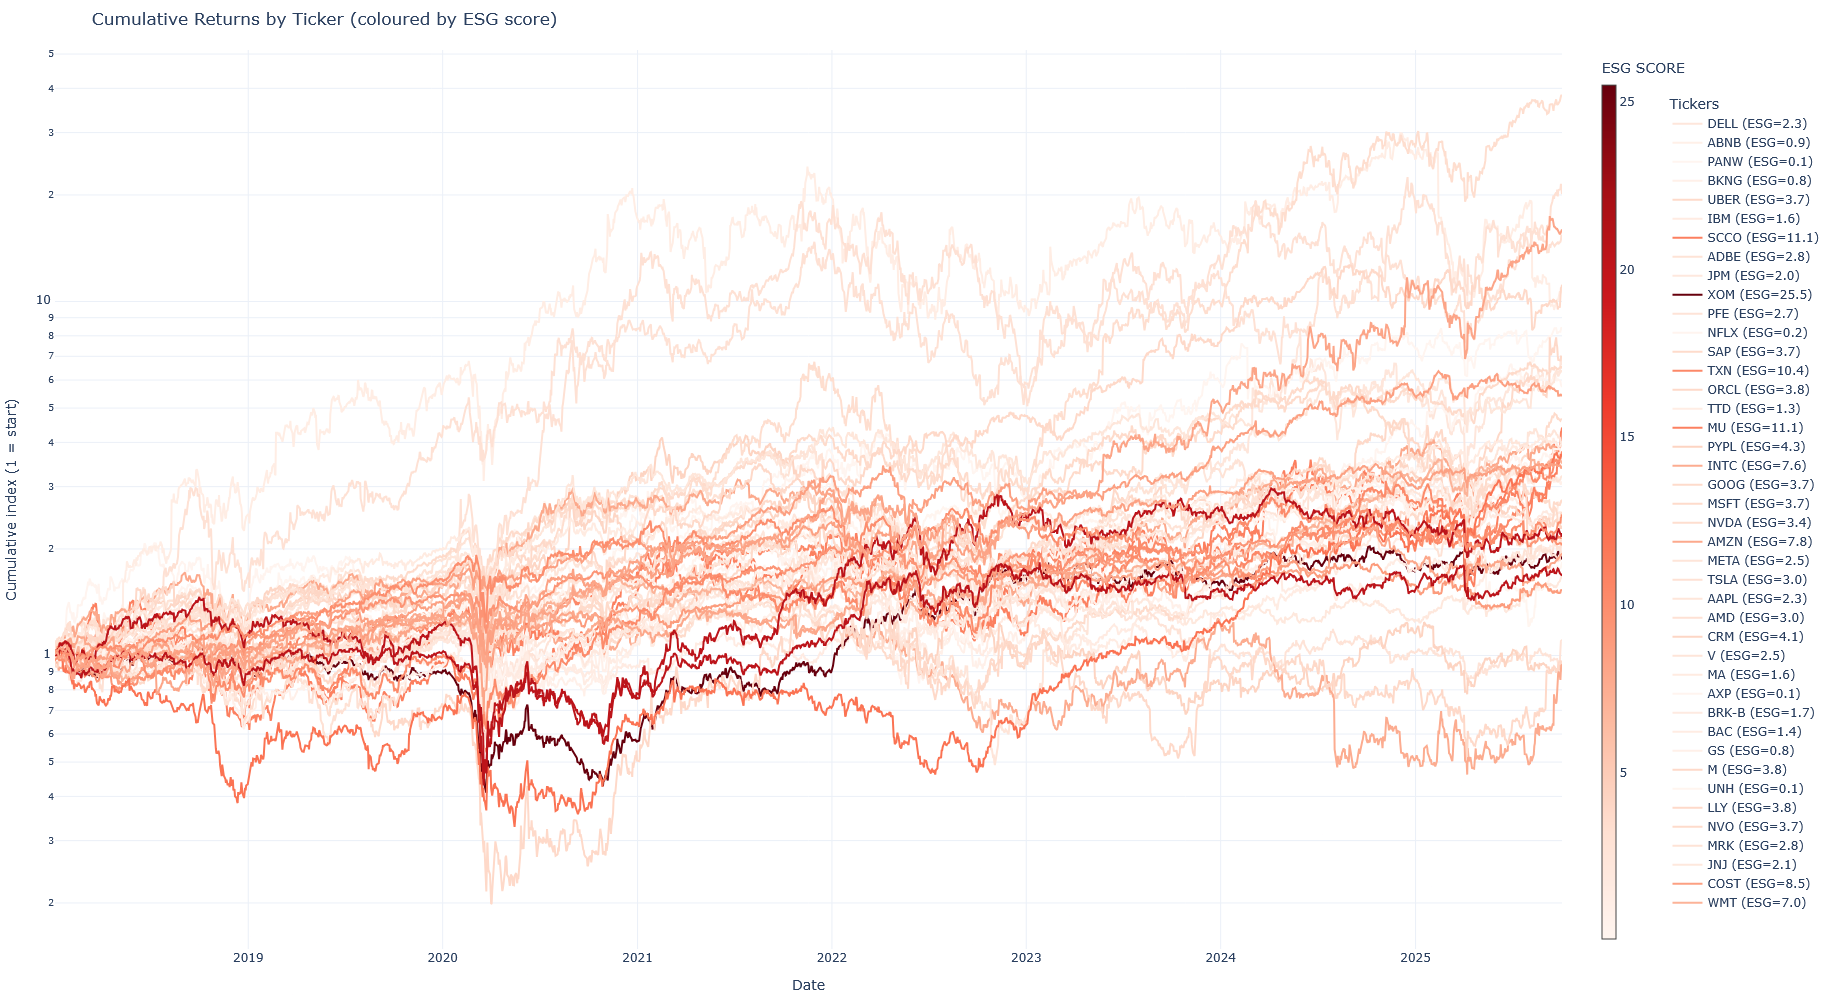

In [7]:
cmin, cmax = float(scores.min()), float(scores.max())
den = (cmax - cmin) if cmax > cmin else 1.0
cscale = 'Reds'  # or 'Turbo', 'Plasma', etc.

# Build figure: one trace per ticker, coloured by ESG score
fig = go.Figure()

for t in cum.columns:
    s = float(scores.loc[t])
    # normalise ESG to [0,1] for colourscale sampling
    v = (s - cmin) / den
    colour = px.colors.sample_colorscale(cscale, v)[0]
    fig.add_trace(
        go.Scatter(
            x=cum.index, y=cum[t],
            mode='lines',
            name=f"{t} (ESG={s:.1f})",
            line=dict(color=colour, width=2),
            hovertemplate=(
                f"<b>{t}</b>: "
                "%{x|%Y-%m-%d}, "
                "Ret=%{y:.3f}, "
                f"ESG:{s:.2f}<extra></extra>"
            )
        )
    )

# Add a dummy (invisible) trace to show a continuous colourbar ---
fig.add_trace(
    go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(
            colorscale=cscale, cmin=cmin, cmax=cmax,
            color=[cmin, cmax], size=12,
            colorbar=dict(title="ESG SCORE", thickness=14)
        ),
        showlegend=False, hoverinfo='none', opacity=0
    )
)

# Layout tweaks ---
fig.update_layout(
    title="Cumulative Returns by Ticker (coloured by ESG score)",
    xaxis_title="Date",
    yaxis_title="Cumulative index (1 = start)",
    template="plotly_white",
    legend_title="Tickers",
    hovermode="x unified",
    legend=dict(
        x=1.07, y=0.95,            # position (fraction of plotting area)
        xanchor="left", yanchor="top",
    ),
    margin=dict(l=50, r=10, t=50, b=40),
    width=1600, height=1000
)

# Optional: log-scale if ranges vary widely
fig.update_yaxes(type='log')

fig.show()

## 2) Portfolio Statistics

We compute mean returns and covariance (daily). Risk-free `rf` is set to `0.0` by default; adjust if needed.

In [8]:
mu = Y.mean()               # daily mean
Sigma = Y.cov()             # daily covariance
rf = 0.0                    # daily risk-free (set your preferred value)

In [11]:
display((mu.nlargest(10)*252).to_frame('Avg Ret (annualised)').style.format('{:.6f}')) # Try nsmallest VS nlargest

### Correlation / Dendrogram
Create helper functions to:
- Convert covariance to correlation;
- Order assets by hierarchical clustering for prettier heatmaps;
- Produce a condensed correlation visual.

Use when you want to discuss co-movement and diversification.

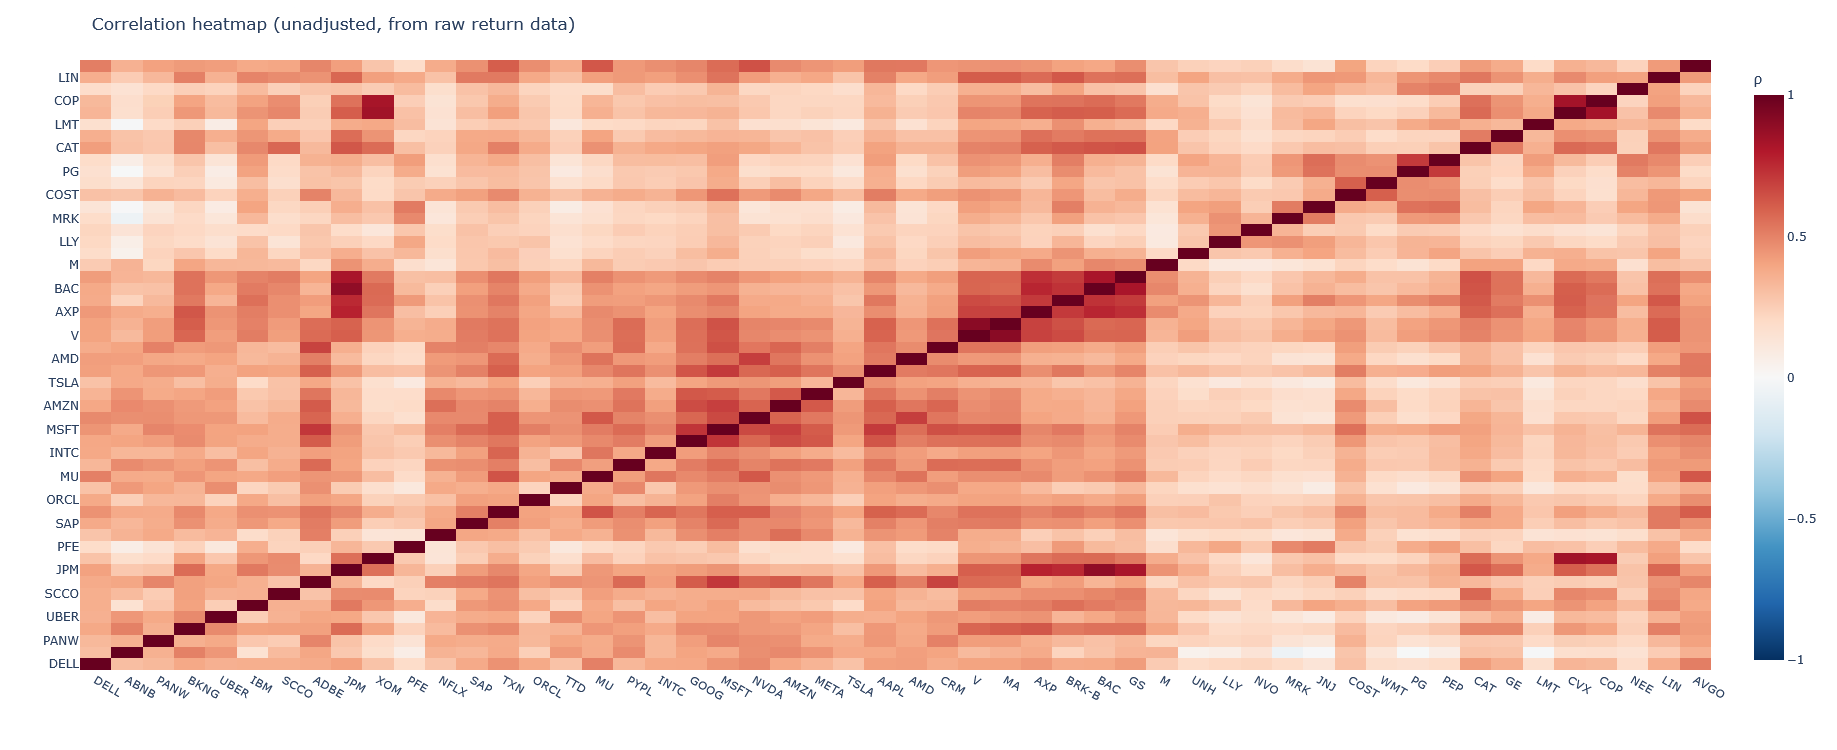

In [12]:
def cov_to_corr(Sigma, names=None):
    """Convert covariance matrix to correlation (handles pd.DataFrame or np.ndarray)."""
    if isinstance(Sigma, pd.DataFrame):
        vals = Sigma.values.astype(float)
        idx = Sigma.index
        cols = Sigma.columns
    else:
        vals = np.asarray(Sigma, dtype=float)
        n = vals.shape[0]
        idx = cols = names if names is not None else [f"a{i}" for i in range(n)]
    # standard deviations
    std = np.sqrt(np.clip(np.diag(vals), a_min=0, a_max=None))
    # avoid divide-by-zero
    std[std == 0] = np.nan
    denom = np.outer(std, std)
    corr_vals = vals / denom
    # numerical tidy-up
    corr_vals = np.clip(corr_vals, -1.0, 1.0)
    return pd.DataFrame(corr_vals, index=idx, columns=cols)

# ---- Build correlation from your Sigma ----
corr = cov_to_corr(Sigma)

# ---- Plotly heatmap ----
fig = px.imshow(
    corr,
    zmin=-1, zmax=1,
    color_continuous_scale="RdBu_r",   # blue = negative, red = positive
    origin="lower",
    aspect="auto",
    labels=dict(color="Correlation")
)
fig.update_layout(
    title="Correlation heatmap (unadjusted, from raw return data)",
    width=900, height=750,
    xaxis_title="", yaxis_title="",
    coloraxis_colorbar=dict(title="ρ")
)
fig.show()


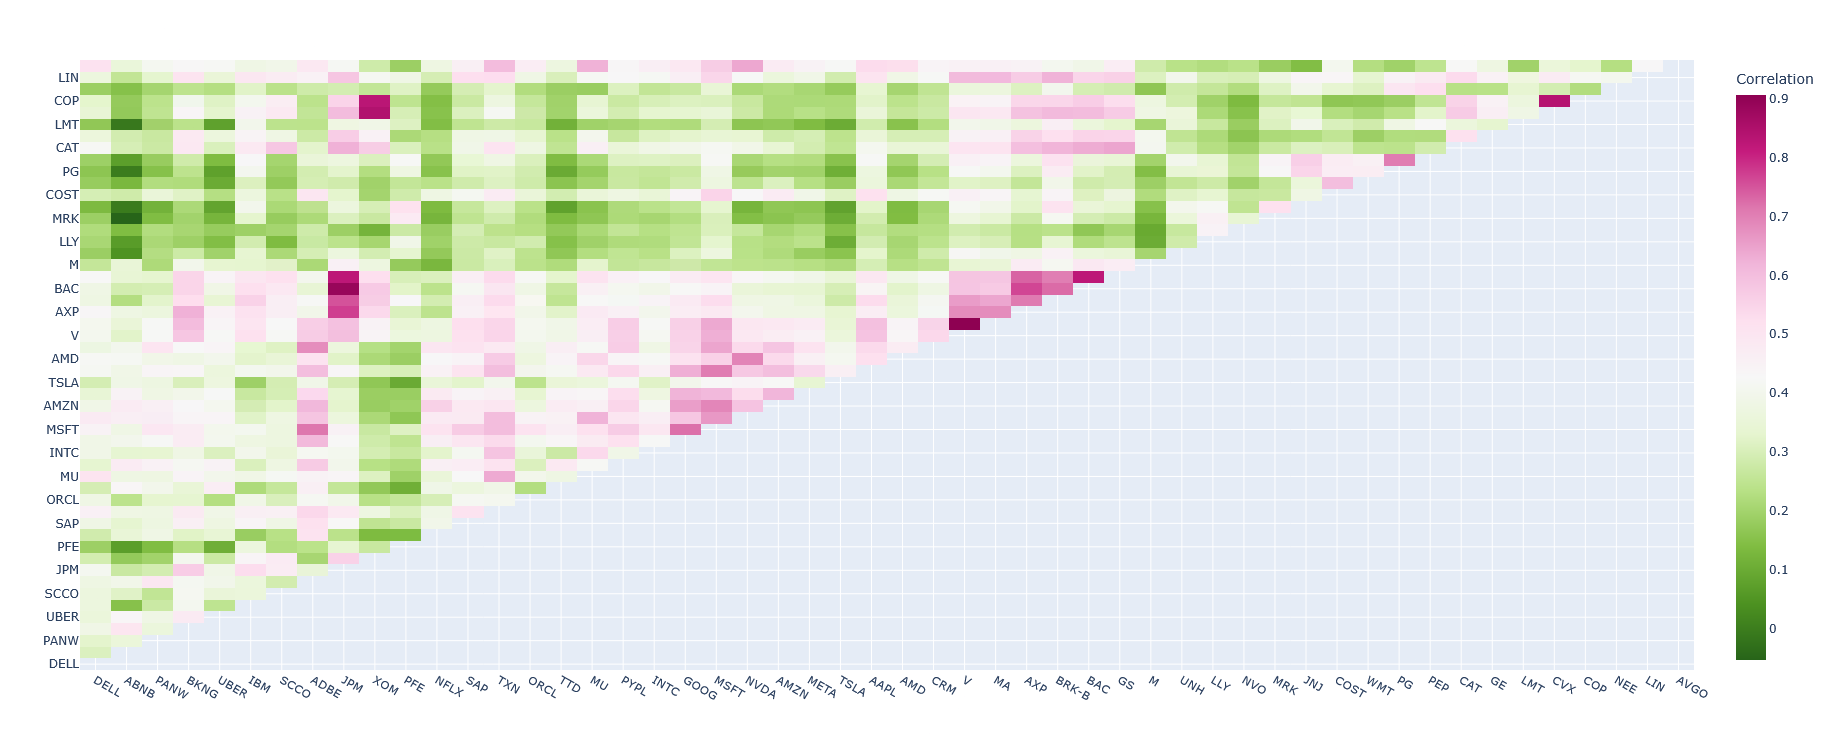

In [13]:
# Optional: upper-triangle mask (to reduce visual clutter)

mask = np.triu(np.ones_like(corr, dtype=bool), k=0) # k=1 (will include the diagonal) k=0 (excludes the diagonal)
corr_masked = corr.mask(mask)
fig = px.imshow(corr_masked, zmin=np.nanmin(corr_masked.values), zmax=np.nanmax(corr_masked.values), color_continuous_scale="PiYG_r",
                origin="lower", aspect="auto", labels=dict(color="Correlation"))
fig.update_layout(width=900, height=750)
fig.show()


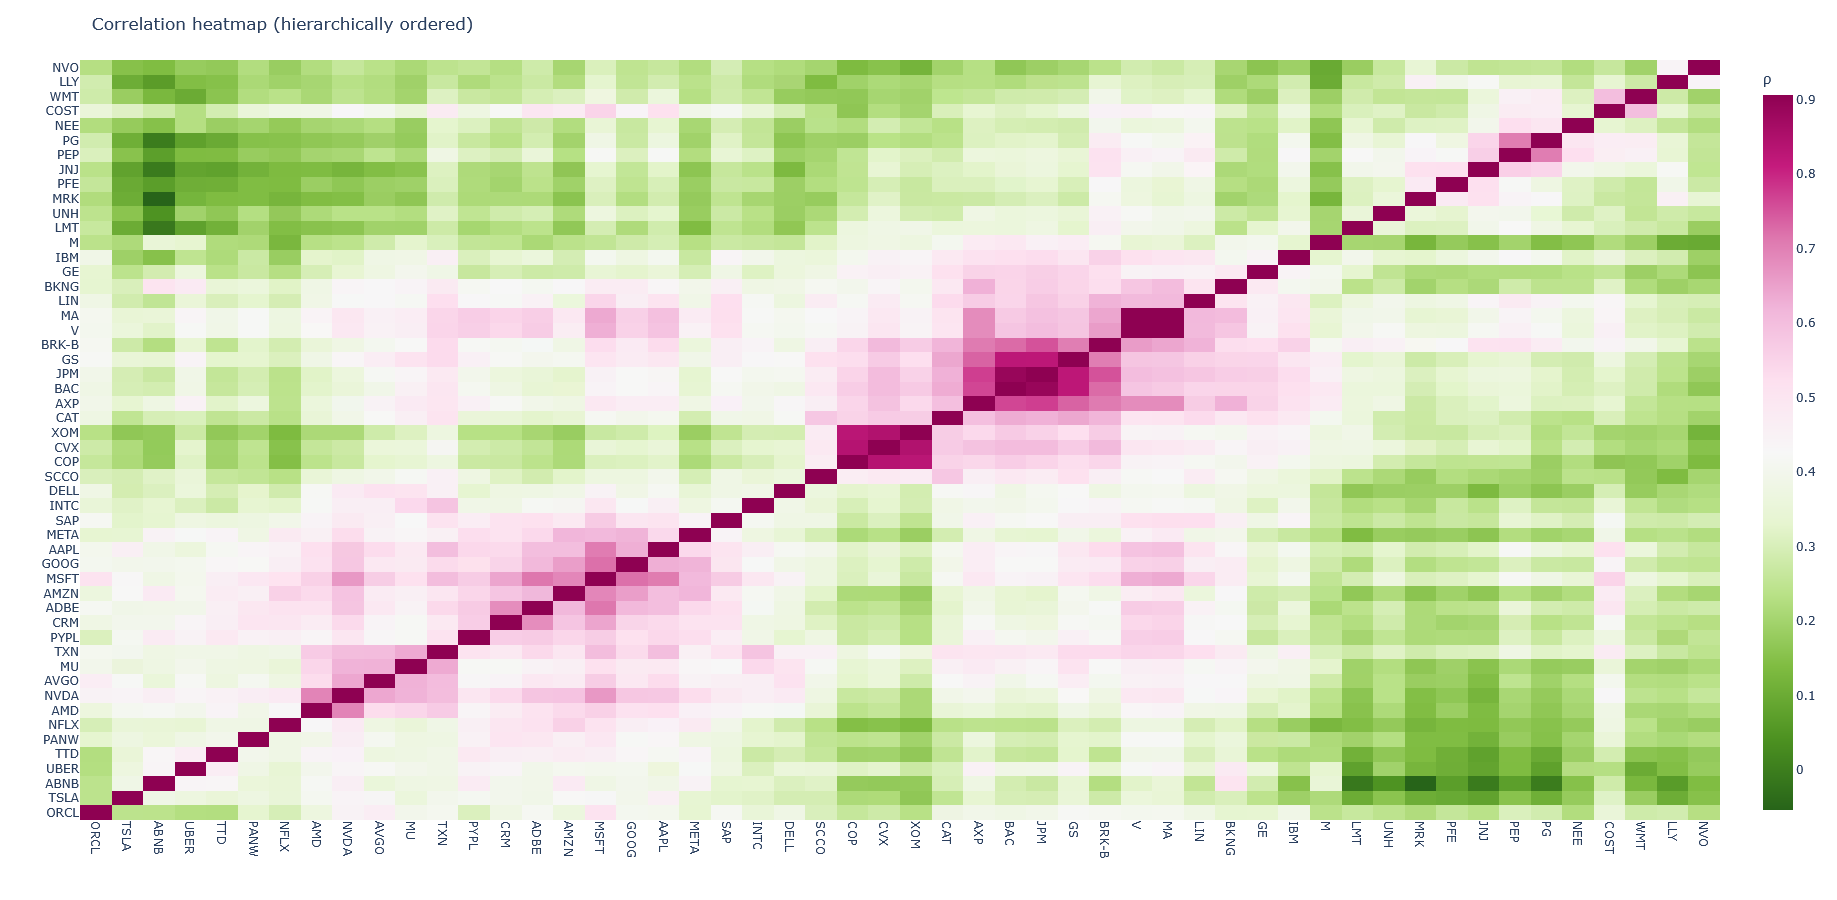

In [14]:
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import squareform

def reorder_corr_by_hclust(corr: pd.DataFrame, method="average", optimal=True):
    """
    Reorder a correlation matrix using hierarchical clustering on
    Mantegna distance d_ij = sqrt(2*(1 - rho_ij)).
    """
    corr = corr.copy().astype(float)
    # drop rows/cols with any NaNs (or impute if preferred)
    keep = corr.notna().all(0) & corr.notna().all(1)
    corr = corr.loc[keep, keep]

    rho = corr.values
    np.fill_diagonal(rho, 1.0)
    # Mantegna distance (symmetric, non-negative)
    D = np.sqrt(2.0 * (1.0 - np.clip(rho, -1.0, 1.0)))
    # condensed vector for linkage
    Dc = squareform(D, checks=False)
    Z = linkage(Dc, method=method)
    if optimal:
        Z = optimal_leaf_ordering(Z, Dc)
    order = leaves_list(Z)

    corr_re = corr.iloc[order, :].iloc[:, order]
    return corr_re

# ---- build correlation from Sigma (your function) ----
corr = cov_to_corr(Sigma)

# ---- reorder by hierarchical clustering ----
corr_re = reorder_corr_by_hclust(corr, method="average", optimal=True)

# ---- compute colour limits excluding the diagonal ----
mask_diag = np.eye(len(corr_re), dtype=bool)
zmin = np.nanmin(corr_re.mask(mask_diag).values)
zmax = np.nanmax(corr_re.mask(mask_diag).values)

# ---- Plotly heatmap ----
fig = px.imshow(
    corr_re,
    zmin=zmin, zmax=zmax,
    color_continuous_scale="PiYG_r",
    origin="lower",
    aspect="auto",
    labels=dict(color="Correlation")
)
fig.update_layout(
    title="Correlation heatmap (hierarchically ordered)",
    width=900,
    height= 900,  # scale height with n
    xaxis_title="", yaxis_title="",
    coloraxis_colorbar=dict(title="ρ")
)
# nicer labels
fig.update_xaxes(tickangle=90)
fig.show()



## 3) Helper Builders for Linear Constraints

We express all constraints in the standard **A w ≤ b** form.

- **Min ESG**: $-\,ESG^\top w \le -\tau$ ensures $ESG^\top w \ge \tau$.  
- **Group caps**: for a set $G$, $\sum_{i\in G} w_i \le cap$ → a row in `A` with ones for the group.  
- **Group floors**: $\sum_{i\in G} w_i \ge floor$ → $-\sum_{i\in G} w_i \le -floor$.


In [15]:
# def min_esg_constraint(esg_scores: pd.Series, target_score: float):
#     # A w <= b for ESG^T w >= target_score  =>  (-ESG)^T w <= -target_score
#     s = esg_scores.reindex(esg_scores.index).astype(float).values
#     A = s.reshape(1, -1)
#     b = np.array([ float(target_score) ])
#     return A, b

def min_esg_constraint(esg_scores: pd.Series, target_score: float):
    # A w <= b for ESG^T w >= target_score  =>  (-ESG)^T w <= -target_score
    s = esg_scores.reindex(esg_scores.index).astype(float).values
    A = -s.reshape(1, -1)
    b = np.array([ -float(target_score) ])
    return A, b
    
def group_cap_constraint(index, group_members, cap):
    row = np.zeros(len(index))
    mask = pd.Index(index).isin(group_members)
    row[mask] = 1.0
    return row.reshape(1, -1), np.array([float(cap)])

def group_floor_constraint(index, group_members, floor):
    row = np.zeros(len(index))
    mask = pd.Index(index).isin(group_members)
    row[mask] = -1.0  # negative for >=
    return row.reshape(1, -1), np.array([-float(floor)])

def stack_constraints(list_of_Ab):
    A_list, b_list = [], []
    for A, b in list_of_Ab:
        if A is not None and b is not None and len(b) > 0:
            A_list.append(np.atleast_2d(A))
            b_list.append(np.atleast_1d(b))
    if not A_list:
        return None, None
    A = np.vstack(A_list)
    b = np.concatenate(b_list)
    return A, b


## 4) Max Sharpe via cvxpy (grid over target return)

To avoid fractional objectives, we **grid** target returns and, for each, solve a **minimum-variance** problem subject to the target and the linear constraints. We then pick the highest Sharpe solution.

That is, because Sharpe ratio is fractional, this solver:
1. Grids **target returns** between the 5th–95th percentiles of individual means;
2. For each target, solves a minimum-variance problem subject to:
    - sum of weights = 1 (fully invested),
    - long-only (≥ 0), and
    - any linear ESG constraints passed as $A w \leq b$
3. Computes the (annualised) Sharpe and returns the best solution.


In [16]:
def solve_max_sharpe_grid(mu, Sigma, rf=0.0, A=None, b=None, n_grid=25, long_only=True, verbose=False):
    mu = mu.reindex(Sigma.index).astype(float)
    Sigma = Sigma.reindex(index=mu.index, columns=mu.index).astype(float)
    n = len(mu)
    w = cp.Variable(n)
    constraints = []
    constraints.append(cp.sum(w) == 1.0)
    if long_only:
        constraints.append(w >= 0.0)
    if A is not None and b is not None:
        constraints.append(A @ w <= b)
    # Prepare target grid
    mu_vals = mu.values
    # Reasonable target range: between 5th and 95th percentile of individual asset means
    lo = np.quantile(mu_vals, 0.05)
    hi = np.quantile(mu_vals, 0.95)
    targets = np.linspace(lo, hi, n_grid)
    best = {'sh': -np.inf, 'w': None, 'ret': None, 'vol': None}
    for t in targets:
        prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)),
                          constraints + [mu.values @ w >= float(t)])
        try:
            prob.solve(solver=cp.SCS, verbose=False)
        except Exception:
            try:
                prob.solve(solver=cp.OSQP, verbose=False)
            except Exception:
                continue
        if w.value is None:
            continue
        wv = np.array(w.value).reshape(-1)
        r = float(mu.values @ wv)
        v = float(np.sqrt(wv @ Sigma.values @ wv + 1e-16))
        sh = (r - rf) / (v + 1e-16)
        if verbose:
            print(f"target={t:.6f}, ret={r:.6f}, vol={v:.6f}, sh={sh:.3f}")
        if np.isfinite(sh) and sh > best['sh']:
            best = {'sh': sh, 'w': wv, 'ret': r, 'vol': v}
    if best['w'] is None:
        raise RuntimeError("No feasible solution found for given constraints.")
    return pd.Series(best['w'], index=mu.index), best


## 5) Approach: **Minimum portfolio ESG** (linear constraint)

We set a threshold $\tau$ (e.g., the 60th percentile of `ESG_SCORE`) and solve for the **max-Sharpe** portfolio such that the portfolio's **weighted-average ESG score**:

$$ \sum_i w_i\,ESG_i \;\ge\; \tau$$

We pick $\tau$ as the 60th percentile of available scores by default (change as needed).


In [17]:
# Fill in any missing values using median scores (this is just to avoid NaN):
esg['ESG_SCORE']= esg['ESG_SCORE'].fillna(esg['ESG_SCORE'].median())

In [18]:
# Choose ESG threshold tau (weighted average >= tau)
tau = float(np.nanpercentile(esg['ESG_SCORE'], 60))
print(f"ESG threshold (tau): {tau:.2f}")

A1, b1 = min_esg_constraint(esg.loc[Y.columns, 'ESG_SCORE'], tau)
w_min_esg, info1 = solve_max_sharpe_grid(mu, Sigma, rf=rf, A=A1, b=b1, n_grid=35)

h1("Approach 1: Weights (min ESG constraint)")
display(w_min_esg.sort_values(ascending=False).to_frame('weight'))
print(f"Return={info1['ret']:.6f}, Vol={info1['vol']:.6f}, Sharpe={info1['sh']:.3f}")


ESG threshold (tau): 22.00

Approach 1: Weights (min ESG constraint)


weight
LLY    0.356552
WMT    0.135866
COST   0.114475
NVDA   0.109653
AVGO   0.085017
TSLA   0.081980
PANW   0.051211
ORCL   0.034895
TTD    0.025530
SCCO   0.005450
AMD    0.000007
MU    -0.000005
UBER  -0.000005
META  -0.000005
GE    -0.000006
XOM   -0.000007
COP   -0.000007
DELL  -0.000007
CVX   -0.000008
CAT   -0.000011
AMZN  -0.000011
GS    -0.000012
MSFT  -0.000013
GOOG  -0.000013
NVO   -0.000013
CRM   -0.000013
AXP   -0.000013
AAPL  -0.000013
NFLX  -0.000014
JPM   -0.000014
BAC   -0.000014
BRK-B -0.000014
NEE   -0.000015
LMT   -0.000015
SAP   -0.000016
M     -0.000017
TXN   -0.000017
INTC  -0.000017
ADBE  -0.000018
PG    -0.000019
PYPL  -0.000019
MA    -0.000020
JNJ   -0.000020
MRK   -0.000020
ABNB  -0.000021
BKNG  -0.000021
V     -0.000022
UNH   -0.000024
PFE   -0.000024
PEP   -0.000028
IBM   -0.000030
LIN   -0.000033

Return=0.001504, Vol=0.014772, Sharpe=0.102


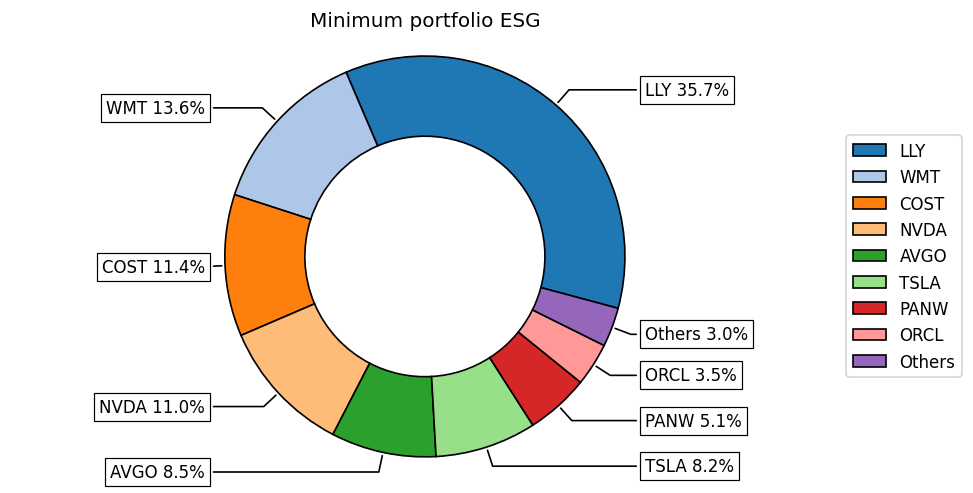

In [19]:
# Plotting the composition of the portfolio
rp.plot_pie(w=w_min_esg, title='Minimum portfolio ESG', others=0.05, nrow=25, cmap = "tab20", height=4, width=8, ax=None);

## 6) Approach: **Group caps / best-in-class**

- Define ESG **quantile groups** (e.g., bottom 30% = **Low**, top 30% = **High**).  
- Constrain total weight of **Low** group to be ≤ `low_cap` (e.g., 20%).  
- Optionally enforce a **minimum** weight for **High** group.

This demonstrates a best-in-class tilt without fully excluding lower-scoring names.

Note: this mirrors many institutional policies: tilt toward high ESG while allowing limited exposure elsewhere.



Approach 5: Weights (group caps)


weight
LLY    3.320496e-01
COST   1.865410e-01
WMT    1.062326e-01
NVDA   9.325295e-02
TSLA   8.071214e-02
AVGO   7.133232e-02
PANW   4.562373e-02
ORCL   3.057582e-02
SCCO   2.726205e-02
TTD    2.089443e-02
NEE    5.495428e-03
PYPL   2.165395e-06
UBER   1.975221e-06
INTC   1.756256e-06
ABNB   1.733973e-06
PEP    1.594274e-06
PFE    1.540244e-06
TXN    1.333326e-06
JNJ    1.310237e-06
MRK    1.305340e-06
AXP    1.295992e-06
M      1.182698e-06
LIN    1.141636e-06
JPM    1.117729e-06
UNH    1.108669e-06
SAP    1.092682e-06
BKNG   1.070610e-06
CRM    1.064984e-06
NVO    1.062087e-06
V      1.055535e-06
MA     1.051768e-06
IBM    9.203473e-07
ADBE   8.264369e-07
GOOG   7.977768e-07
AAPL   6.768988e-07
MU     6.718811e-07
MSFT   5.048432e-07
DELL   4.343521e-07
AMD    3.434387e-07
CVX    2.229968e-07
COP    1.347111e-07
NFLX   1.132799e-07
XOM   -1.930589e-08
BAC   -5.616457e-08
PG    -2.817754e-07
LMT   -3.046681e-07
BRK-B -3.468438e-07
GE    -4.402589e-07
GS    -5.314380e-07
CAT   -6.314527e-07
META  -1.026824e-06
AMZN  -1.053191e-06

Return=0.001452, Vol=0.014291, Sharpe=0.102


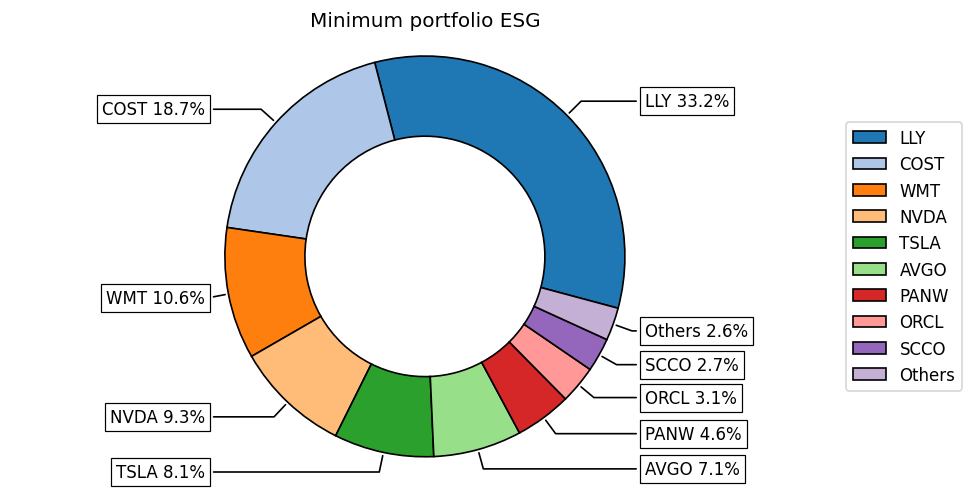

In [20]:
# Build ESG quantile groups
scores = esg.loc[Y.columns, 'ESG_SCORE']
q_low, q_high = np.nanpercentile(scores, [30, 70])
low_group  = scores.index[scores <= q_low].tolist()
high_group = scores.index[scores >= q_high].tolist()

low_cap = 0.20     # <= 20% in bottom-ESG group
high_floor = 0.30  # >= 30% in top-ESG group (set to 0.0 to disable)

A_list, b_list = [], []

A_low, b_low = group_cap_constraint(Y.columns, low_group, low_cap)
A_list.append(A_low); b_list.append(b_low)

if high_floor > 0:
    A_high, b_high = group_floor_constraint(Y.columns, high_group, high_floor)
    A_list.append(A_high); b_list.append(b_high)

A5, b5 = stack_constraints(list(zip(A_list, b_list)))

w_group_caps, info5 = solve_max_sharpe_grid(mu, Sigma, rf=rf, A=A5, b=b5, n_grid=35)

h1("Approach 5: Weights (group caps)")
display(w_group_caps.sort_values(ascending=False).to_frame('weight'))
print(f"Return={info5['ret']:.6f}, Vol={info5['vol']:.6f}, Sharpe={info5['sh']:.3f}")

# Plotting the composition of the portfolio
rp.plot_pie(w=w_group_caps, title='Minimum portfolio ESG', others=0.05, nrow=25, cmap = "tab20", height=4, width=8, ax=None);

## 7) Approach: **ESG-driven clustering with cluster caps**

1. Cluster assets using **ESG features** (E, S, G and controversy if available).
2. Standardise features;
3. Cluster assets (e.g., Agglomerative/Ward);
4. Impose **cluster caps** to prevent concentration in any single ESG profile.
5. Solve max-Sharpe under these cluster caps;
6. Inspect assignments, weights, and portfolio metrics.

We use hierarchical clustering (Ward) on **standardised** ESG features, then cap each cluster at e.g. **35%**.


Cluster assignment


cluster
DELL         1
ABNB         1
PANW         1
BKNG         1
UBER         0
IBM          1
SCCO         0
ADBE         1
JPM          1
XOM          0
PFE          1
NFLX         1
SAP          1
TXN          1
ORCL         1
TTD          1
MU           1
PYPL         1
INTC         1
GOOG         1
MSFT         1
NVDA         1
AMZN         0
META         0
TSLA         0
AAPL         0
AMD          1
CRM          1
V            0
MA           0
AXP          1
BRK-B        2
BAC          1
GS           1
M            1
UNH          0
LLY          0
NVO          1
MRK          1
JNJ          0
COST         1
WMT          1
PG           1
PEP          1
CAT          1
GE           1
LMT          1
CVX          0
COP          0
NEE          1
LIN          1
AVGO         1


Approach 7: Weights (ESG cluster caps)


weight
BRK-B  2.999964e-01
LLY    2.824583e-01
NVDA   1.039921e-01
WMT    6.914080e-02
TSLA   6.754083e-02
COST   5.924372e-02
AVGO   5.886287e-02
PANW   3.529258e-02
TTD    2.307609e-02
ORCL   3.911621e-04
CVX    2.156748e-07
XOM    2.051612e-07
JNJ    1.957052e-07
COP    1.924872e-07
UNH    1.885388e-07
V      1.752736e-07
ABNB   1.645368e-07
UBER   1.631667e-07
PYPL   1.623805e-07
MA     1.616968e-07
SCCO   1.590705e-07
INTC   1.541885e-07
AMZN   1.498975e-07
PFE    1.467425e-07
META   1.391435e-07
BAC    1.383128e-07
PEP    1.311817e-07
M      1.287146e-07
TXN    1.255803e-07
AAPL   1.230286e-07
LMT    1.175938e-07
ADBE   1.160473e-07
PG     1.093789e-07
MRK    1.069588e-07
CRM    1.066556e-07
BKNG   1.054050e-07
JPM    1.051425e-07
IBM    1.031987e-07
SAP    1.020900e-07
AXP    1.016179e-07
GS     1.013889e-07
NEE    9.837508e-08
LIN    9.820436e-08
CAT    9.526637e-08
GE     8.538620e-08
NVO    7.664622e-08
GOOG   7.518619e-08
MU     6.807287e-08
MSFT   5.193164e-08
DELL   3.591989e-08
NFLX   3.257054e-08
AMD   -1.931729e-08

Return=0.001295, Vol=0.013623, Sharpe=0.095


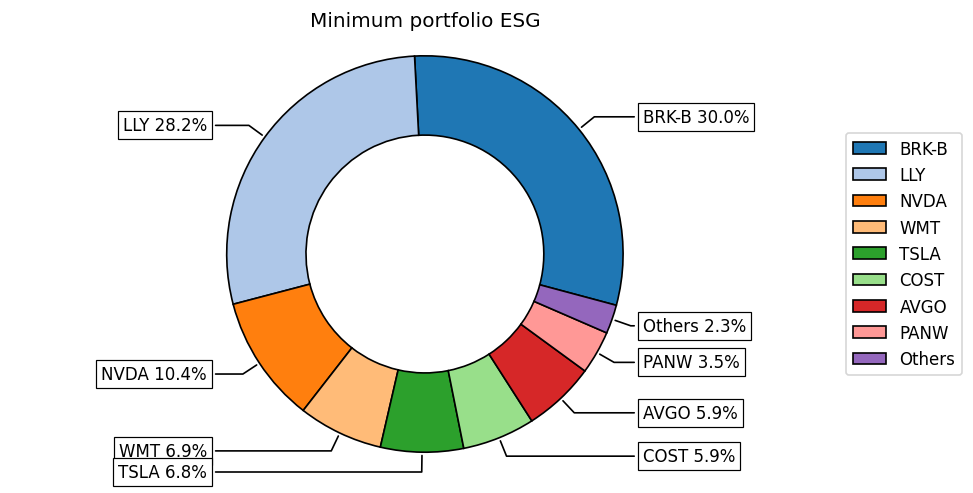

In [21]:

# Prepare ESG features for clustering
features = ['env_score','soc_score','gov_score']
# If controversy is available (higher worse), include it with a negative sign so higher = better after transform
if esg['controversy'].notna().any():
    esg_feat = esg.loc[Y.columns, features].copy()
    esg_feat = esg_feat.join(-esg.loc[Y.columns, ['controversy']].rename(columns={'controversy':'anti_controversy'}))
else:
    esg_feat = esg.loc[Y.columns, features].copy()

esg_feat = esg_feat.fillna(esg_feat.median())
X = StandardScaler().fit_transform(esg_feat.values)

# Cluster
n_clusters = 3
clu = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = clu.fit_predict(X)

clusters = pd.Series(labels, index=esg_feat.index, name='cluster')
h1("Cluster assignment")
display(clusters.to_frame())

# Build cluster caps
cluster_cap = 0.35
Ab = []
for c in range(n_clusters):
    members = clusters.index[clusters==c].tolist()
    A_c, b_c = group_cap_constraint(Y.columns, members, cluster_cap)
    Ab.append((A_c, b_c))

A7, b7 = stack_constraints(Ab)

w_cluster_caps, info7 = solve_max_sharpe_grid(mu, Sigma, rf=rf, A=A7, b=b7, n_grid=35)

h1("Approach 7: Weights (ESG cluster caps)")
display(w_cluster_caps.sort_values(ascending=False).to_frame('weight'))
print(f"Return={info7['ret']:.6f}, Vol={info7['vol']:.6f}, Sharpe={info7['sh']:.3f}")

# Plotting the composition of the portfolio
rp.plot_pie(w=w_cluster_caps, title='Minimum portfolio ESG', others=0.05, nrow=25, cmap = "tab20", height=4, width=8, ax=None);


## 8) Plot portfolio return series (Riskfolio-Lib)

We plot the return series of the **three** ESG-aware portfolios using `rp.plot_series`.

Interpretation: compare paths, drawdowns, and relative behaviour over time.

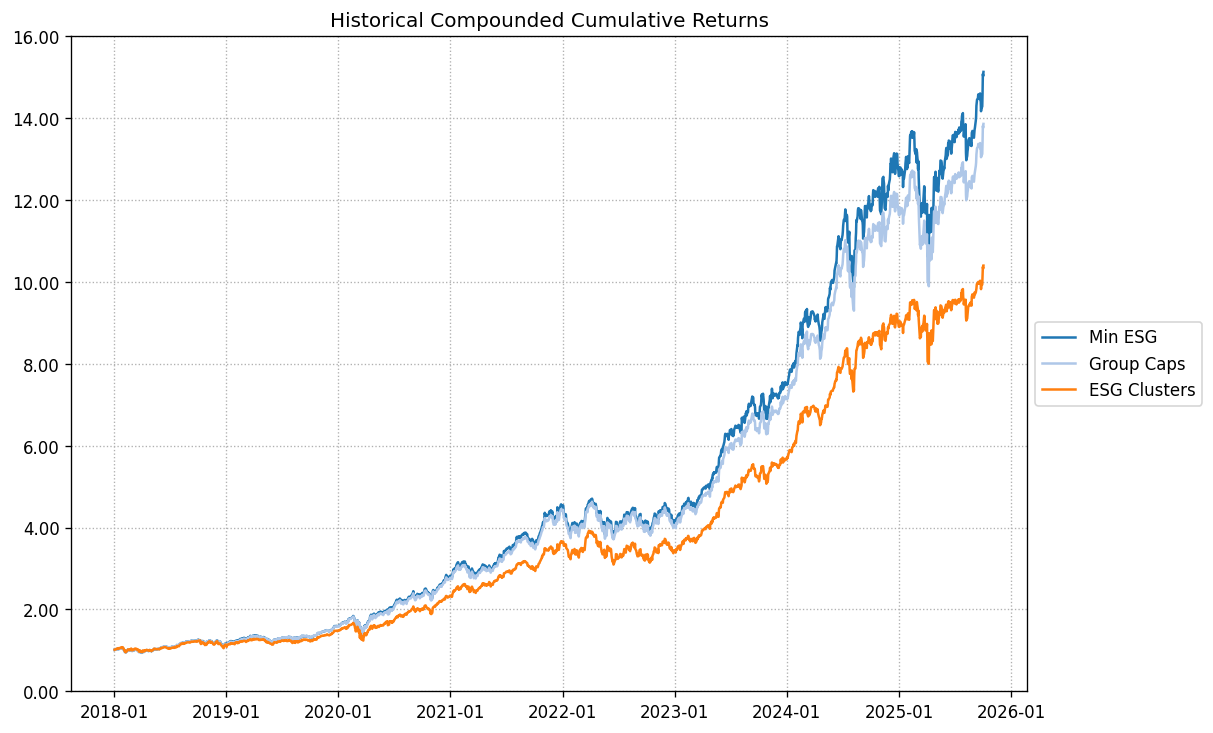

In [22]:
# Assemble weights matrix
ws = pd.concat([
    w_min_esg.rename('Min ESG'),
    w_group_caps.rename('Group Caps'),
    w_cluster_caps.rename('ESG Clusters')
], axis=1)

# Plot
ax = rp.plot_series(returns=Y.fillna(0),
                    w=ws,
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)
plt.show()



## 9) Next steps / variations

- Replace daily mean/cov with **robust** estimators (e.g., `method_mu='hist'`, `method_cov='ledoit'`) via Riskfolio-Lib stats helpers.  
- Add **tracking error** constraints to a benchmark while requiring an **ESG uplift**.  
- Combine approaches (e.g., cluster caps **and** min ESG).  
- Use **Black–Litterman** to encode soft ESG outperformance views instead of hard constraints.


## 10) More on clustering (unsupervised machine learning) and other approaches

Below are some helper functions so we can focus on ideas rather than coding:

In [23]:
# ============================================================================
# 1. DATA PREPARATION
# ============================================================================

def prepare_clustering_data(returns, esg_scores, annualize=True):
    """
    Prepare features for clustering analysis.
    
    Parameters
    ----------
    returns : pd.DataFrame
        Asset returns (rows=dates, columns=assets)
    esg_scores : pd.DataFrame or pd.Series
        ESG risk scores (higher = more risk)
    annualize : bool, default True
        Whether to annualize return statistics
    
    Returns
    -------
    pd.DataFrame
        Feature matrix with ESG and return characteristics
    """
    
    # Calculate return statistics
    factor = 252 if annualize else 1
    mean_returns = returns.mean() * factor
    volatility = returns.std() * np.sqrt(factor)
    sharpe_ratio = mean_returns / volatility
    
    # Calculate downside metrics
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(factor)
    
    # Maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Combine features
    if isinstance(esg_scores, pd.Series):
        esg_data = esg_scores
    else:
        esg_data = esg_scores.iloc[0]  # Assuming static ESG scores
    
    features = pd.DataFrame({
        'ESG_Risk': esg_data,
        'Ann_Return': mean_returns,
        'Ann_Volatility': volatility,
        'Sharpe_Ratio': sharpe_ratio,
        'Downside_Vol': downside_vol.fillna(volatility),
        'Max_Drawdown': max_drawdown
    })
    
    return features


# ============================================================================
# 2. OPTIMAL NUMBER OF CLUSTERS
# ============================================================================

def find_optimal_clusters(features_scaled, max_clusters=10):
    """
    Find optimal number of clusters using multiple metrics.
    
    Parameters
    ----------
    features_scaled : np.ndarray
        Scaled feature matrix
    max_clusters : int, default 10
        Maximum number of clusters to test
    
    Returns
    -------
    dict
        Dictionary with metrics for each cluster count
    """
    
    metrics = {
        'n_clusters': [],
        'inertia': [],
        'silhouette': [],
        'davies_bouldin': []
    }
    
    for n in range(2, min(max_clusters + 1, len(features_scaled))):
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features_scaled)
        
        metrics['n_clusters'].append(n)
        metrics['inertia'].append(kmeans.inertia_)
        metrics['silhouette'].append(silhouette_score(features_scaled, labels))
        metrics['davies_bouldin'].append(davies_bouldin_score(features_scaled, labels))
    
    return pd.DataFrame(metrics)


def plot_cluster_metrics(metrics_df):
    """Plot metrics for determining optimal number of clusters."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Elbow plot
    axes[0].plot(metrics_df['n_clusters'], metrics_df['inertia'], 
                marker='o', linewidth=2.5, markersize=8, color='#e74c3c')
    axes[0].set_xlabel('Number of Clusters', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=11, fontweight='bold')
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold', pad=15)
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette score (higher is better)
    axes[1].plot(metrics_df['n_clusters'], metrics_df['silhouette'], 
                marker='s', linewidth=2.5, markersize=8, color='#3498db')
    axes[1].set_xlabel('Number of Clusters', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
    axes[1].set_title('Silhouette Analysis (Higher is Better)', fontsize=14, fontweight='bold', pad=15)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
    axes[1].legend()
    
    # Davies-Bouldin score (lower is better)
    axes[2].plot(metrics_df['n_clusters'], metrics_df['davies_bouldin'], 
                marker='^', linewidth=2.5, markersize=8, color='#2ecc71')
    axes[2].set_xlabel('Number of Clusters', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Davies-Bouldin Score', fontsize=11, fontweight='bold')
    axes[2].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold', pad=15)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Recommend optimal number
    best_silhouette = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'n_clusters']
    best_db = metrics_df.loc[metrics_df['davies_bouldin'].idxmin(), 'n_clusters']
    
    print(f"\n{'='*60}")
    print("RECOMMENDED NUMBER OF CLUSTERS:")
    print(f"{'='*60}")
    print(f"Based on Silhouette Score: {int(best_silhouette)} clusters")
    print(f"Based on Davies-Bouldin Index: {int(best_db)} clusters")
    print(f"{'='*60}\n")
    
    return int(best_silhouette)


# ============================================================================
# 3. CLUSTERING ALGORITHMS
# ============================================================================

def perform_clustering(features_scaled, n_clusters=4, method='kmeans'):
    """
    Perform clustering using specified method.
    
    Parameters
    ----------
    features_scaled : np.ndarray
        Scaled feature matrix
    n_clusters : int, default 4
        Number of clusters
    method : str, default 'kmeans'
        Clustering method: 'kmeans', 'hierarchical', or 'dbscan'
    
    Returns
    -------
    np.ndarray
        Cluster labels
    """
    
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = model.fit_predict(features_scaled)
        
    elif method == 'hierarchical':
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        labels = model.fit_predict(features_scaled)
        
    elif method == 'dbscan':
        model = DBSCAN(eps=0.5, min_samples=2)
        labels = model.fit_predict(features_scaled)
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return labels


# ============================================================================
# 4. VISUALIZATION
# ============================================================================

def plot_clusters_pca(features, labels, feature_names):
    """
    Visualize clusters in 2D using PCA.
    
    Parameters
    ----------
    features : pd.DataFrame
        Original features
    labels : np.ndarray
        Cluster labels
    feature_names : list
        Names of features for labeling
    """
    
    # Perform PCA
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Define colors
    n_clusters = len(np.unique(labels[labels >= 0]))
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    
    # Plot each cluster
    for i, cluster_id in enumerate(np.unique(labels)):
        if cluster_id == -1:  # Noise points for DBSCAN
            color = 'gray'
            label = 'Noise'
            alpha = 0.3
        else:
            color = colors[cluster_id]
            label = f'Cluster {cluster_id}'
            alpha = 0.7
        
        mask = labels == cluster_id
        ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
                  c=[color], label=label, s=200, alpha=alpha,
                  edgecolors='white', linewidth=1.5)
        
        # Add asset labels
        for idx in np.where(mask)[0]:
            ax.annotate(features.index[idx], 
                       (features_pca[idx, 0], features_pca[idx, 1]),
                       fontsize=9, alpha=0.8,
                       xytext=(5, 5), textcoords='offset points')
    
    # Labels and formatting
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
                 fontsize=13, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
                 fontsize=13, fontweight='bold')
    ax.set_title('Asset Clusters in PCA Space (ESG + Return Characteristics)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='best', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print PCA loadings
    print(f"\n{'='*60}")
    print("PCA COMPONENT LOADINGS:")
    print(f"{'='*60}")
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=feature_names
    )
    print(loadings.round(3))
    print(f"{'='*60}\n")


def plot_cluster_characteristics(features, labels, min_scale=0.1):
    """
    Plot radar chart showing characteristics of each cluster.
    
    Parameters
    ----------
    features : pd.DataFrame
        Original features
    labels : np.ndarray
        Cluster labels
    min_scale : float, default 0.1
        Minimum value for scaling (to avoid flat lines at zero)
    """
    
    # Calculate cluster means
    features_with_clusters = features.copy()
    features_with_clusters['Cluster'] = labels
    cluster_means = features_with_clusters.groupby('Cluster').mean()
    
    # Normalize for radar chart (0-1 scale)
    # Scale to [min_scale, 1.0] instead of [0, 1]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(min_scale, 1.0))
    cluster_means_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_means),
        columns=cluster_means.columns,
        index=cluster_means.index
    )
    
    # Create radar chart
    n_clusters = len(cluster_means)
    n_features = len(features.columns)
    
    angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    
    for i, cluster_id in enumerate(cluster_means_scaled.index):
        values = cluster_means_scaled.loc[cluster_id].tolist()
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2.5, label=f'Cluster {cluster_id}',
               color=colors[i])
        ax.fill(angles, values, alpha=0.15, color=colors[i])
    
    # Labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features.columns, fontsize=11, fontweight='bold')
    
    # Set y-axis limits from 0 but show gridlines starting from min_scale
    ax.set_ylim(0, 1)
    
    ax.set_title('Cluster Characteristics Profile (Normalized)', 
                fontsize=16, fontweight='bold', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_hierarchical_dendrogram(features_scaled, feature_index):
    """
    Plot dendrogram for hierarchical clustering.
    
    Parameters
    ----------
    features_scaled : np.ndarray
        Scaled feature matrix
    feature_index : pd.Index
        Asset names
    """
    
    linkage_matrix = linkage(features_scaled, method='ward')
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    dendrogram(linkage_matrix, 
              labels=feature_index,
              leaf_rotation=90,
              leaf_font_size=10,
              ax=ax)
    
    ax.set_xlabel('Assets', fontsize=13, fontweight='bold')
    ax.set_ylabel('Distance', fontsize=13, fontweight='bold')
    ax.set_title('Hierarchical Clustering Dendrogram', 
                fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# 5. CLUSTER ANALYSIS & PORTFOLIO CONSTRUCTION
# ============================================================================

def analyze_clusters(features, labels):
    """
    Analyze and describe each cluster.
    
    Parameters
    ----------
    features : pd.DataFrame
        Original features
    labels : np.ndarray
        Cluster labels
    
    Returns
    -------
    pd.DataFrame
        Cluster statistics
    """
    
    features_with_clusters = features.copy()
    features_with_clusters['Cluster'] = labels
    
    # Calculate statistics per cluster
    cluster_stats = features_with_clusters.groupby('Cluster').agg({
        'ESG_Risk': ['mean', 'std', 'count'],
        'Ann_Return': ['mean', 'std'],
        'Ann_Volatility': ['mean', 'std'],
        'Sharpe_Ratio': ['mean', 'std']
    }).round(4)
    
    print(f"\n{'='*80}")
    print("CLUSTER ANALYSIS:")
    print(f"{'='*80}")
    print(cluster_stats)
    print(f"{'='*80}\n")
    
    # Describe each cluster
    for cluster_id in sorted(features_with_clusters['Cluster'].unique()):
        if cluster_id == -1:
            print(f"Cluster {cluster_id} (Noise): Outlier assets")
        else:
            cluster_data = features_with_clusters[features_with_clusters['Cluster'] == cluster_id]
            print(f"\nCluster {cluster_id} ({len(cluster_data)} assets):")
            print(f"  Assets: {', '.join(cluster_data.index.tolist())}")
            print(f"  Avg ESG Risk: {cluster_data['ESG_Risk'].mean():.2f}")
            print(f"  Avg Return: {cluster_data['Ann_Return'].mean()*100:.2f}%")
            print(f"  Avg Volatility: {cluster_data['Ann_Volatility'].mean()*100:.2f}%")
            print(f"  Avg Sharpe: {cluster_data['Sharpe_Ratio'].mean():.3f}")
    
    return cluster_stats


def construct_cluster_portfolio(features, labels, returns, method='equal_weight'):
    """
    Construct portfolio based on cluster allocation.
    
    Parameters
    ----------
    features : pd.DataFrame
        Original features with assets as index
    labels : np.ndarray
        Cluster labels
    returns : pd.DataFrame
        Asset returns
    method : str, default 'equal_weight'
        Allocation method: 'equal_weight', 'inverse_esg', 'sharpe_weighted'
    
    Returns
    -------
    pd.Series
        Portfolio weights
    """
    
    features_with_clusters = features.copy()
    features_with_clusters['Cluster'] = labels
    
    # Equal weight across clusters, then within clusters
    n_clusters = len(features_with_clusters[features_with_clusters['Cluster'] >= 0]['Cluster'].unique())
    cluster_weight = 1.0 / n_clusters
    
    weights = pd.Series(0.0, index=features.index)
    
    for cluster_id in features_with_clusters['Cluster'].unique():
        if cluster_id == -1:  # Skip noise
            continue
        
        cluster_assets = features_with_clusters[features_with_clusters['Cluster'] == cluster_id]
        n_assets = len(cluster_assets)
        
        if method == 'equal_weight':
            asset_weight = cluster_weight / n_assets
            weights[cluster_assets.index] = asset_weight
            
        elif method == 'inverse_esg':
            # Weight inversely to ESG risk (lower risk = higher weight)
            inverse_esg = 1.0 / cluster_assets['ESG_Risk']
            normalized_weights = inverse_esg / inverse_esg.sum()
            weights[cluster_assets.index] = normalized_weights * cluster_weight
            
        elif method == 'sharpe_weighted':
            # Weight by Sharpe ratio
            sharpe_weights = cluster_assets['Sharpe_Ratio'].clip(lower=0)
            if sharpe_weights.sum() > 0:
                normalized_weights = sharpe_weights / sharpe_weights.sum()
                weights[cluster_assets.index] = normalized_weights * cluster_weight
            else:
                asset_weight = cluster_weight / n_assets
                weights[cluster_assets.index] = asset_weight
    
    # Normalize to sum to 1
    weights = weights / weights.sum()
    
    print(f"\n{'='*80}")
    print(f"CLUSTER-BASED PORTFOLIO (Method: {method}):")
    print(f"{'='*80}")
    print(weights[weights > 0].sort_values(ascending=False))
    print(f"\nTotal weight: {weights.sum():.6f}")
    print(f"{'='*80}\n")
    
    return weights

Suppose you only have **returns** (in some DataFrame `Y`) and some **additional data**, for example, ESG scores (let's say, in variable `E`):

In [24]:
# My returns are in variable Y, missing return values (if any) are substituted by zeros:
Y = Y.fillna(0)

# My ESG data are in variable E, missing return values (if any) are substituted by median values:
E = esg.reindex(cum.columns)['env_score'].astype(float)
E = E.fillna(scores.median())

In [25]:
# Step 1: Prepare data
features = prepare_clustering_data(Y, E, annualize=True)
print("Features prepared:")
features.head()

Features prepared:


ESG_Risk  Ann_Return  Ann_Volatility  Sharpe_Ratio  Downside_Vol  \
DELL      2.31    0.337206        0.431704      0.781106      0.325677   
ABNB      0.88    0.046618        0.376393      0.123853      0.312845   
PANW      0.05    0.350560        0.386516      0.906974      0.298221   
BKNG      0.83    0.202118        0.336888      0.599957      0.245059   
UBER      3.74    0.219017        0.473461      0.462588      0.329572   

      Max_Drawdown  
DELL     -0.595877  
ABNB     -0.619581  
PANW     -0.479834  
BKNG     -0.477700  
UBER     -0.680466

In [26]:
# Step 2: Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

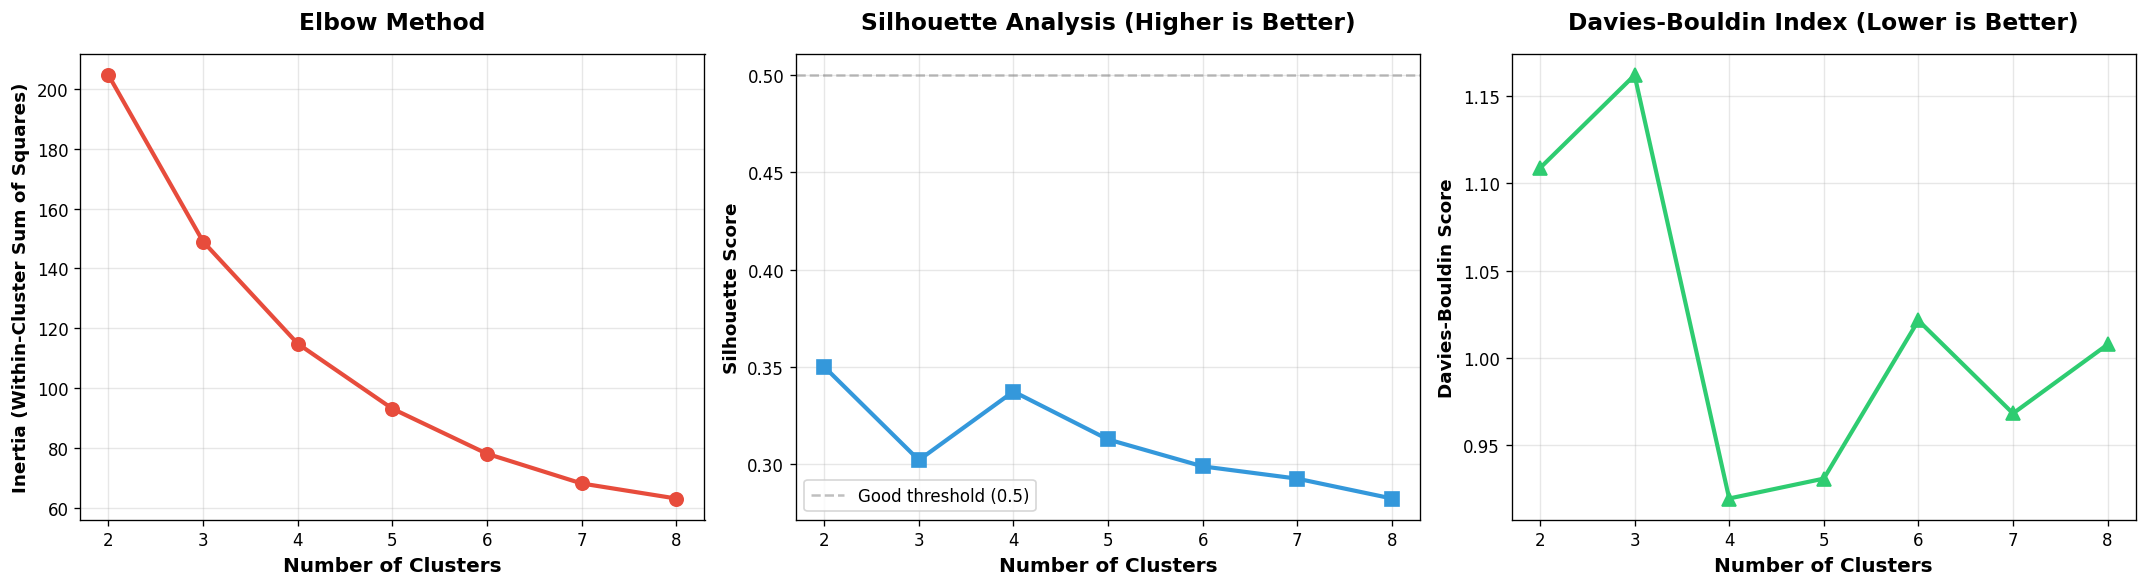


RECOMMENDED NUMBER OF CLUSTERS:
Based on Silhouette Score: 2 clusters
Based on Davies-Bouldin Index: 4 clusters



In [27]:
# Step 3: Find optimal number of clusters
metrics = find_optimal_clusters(features_scaled, max_clusters=8)
optimal_k = plot_cluster_metrics(metrics)

In [28]:
print(f"The optimal number of clusters selected automatically is: {optimal_k} clusters")

The optimal number of clusters selected automatically is: 2 clusters


In [29]:
# You can overwrite this:
optimal_k = 5

In [30]:
# Step 4: Perform clustering. Choose from 'kmeans', 'hierarchical', or 'dbscan'
labels_kmeans = perform_clustering(features_scaled, n_clusters=optimal_k, method='hierarchical')

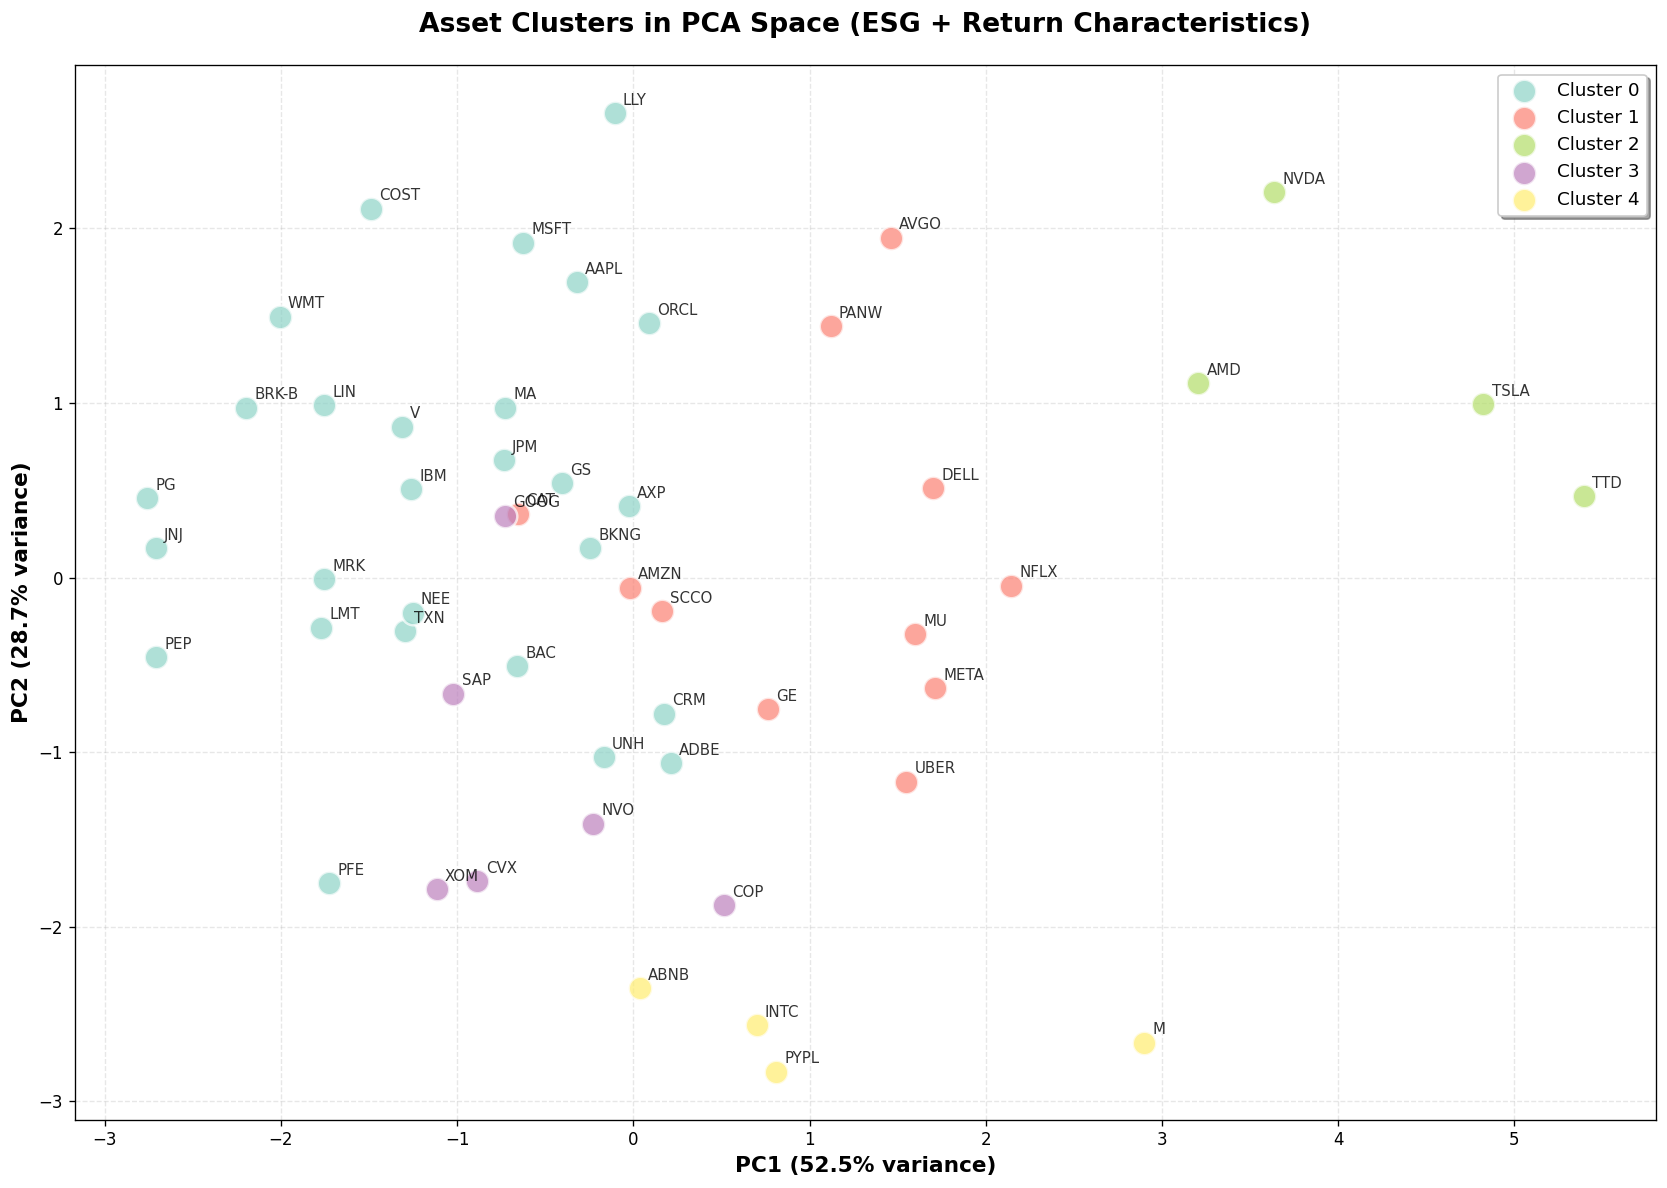


PCA COMPONENT LOADINGS:
                  PC1    PC2
ESG_Risk       -0.122 -0.232
Ann_Return      0.435  0.458
Ann_Volatility  0.550 -0.105
Sharpe_Ratio    0.147  0.706
Downside_Vol    0.543 -0.155
Max_Drawdown   -0.421  0.450



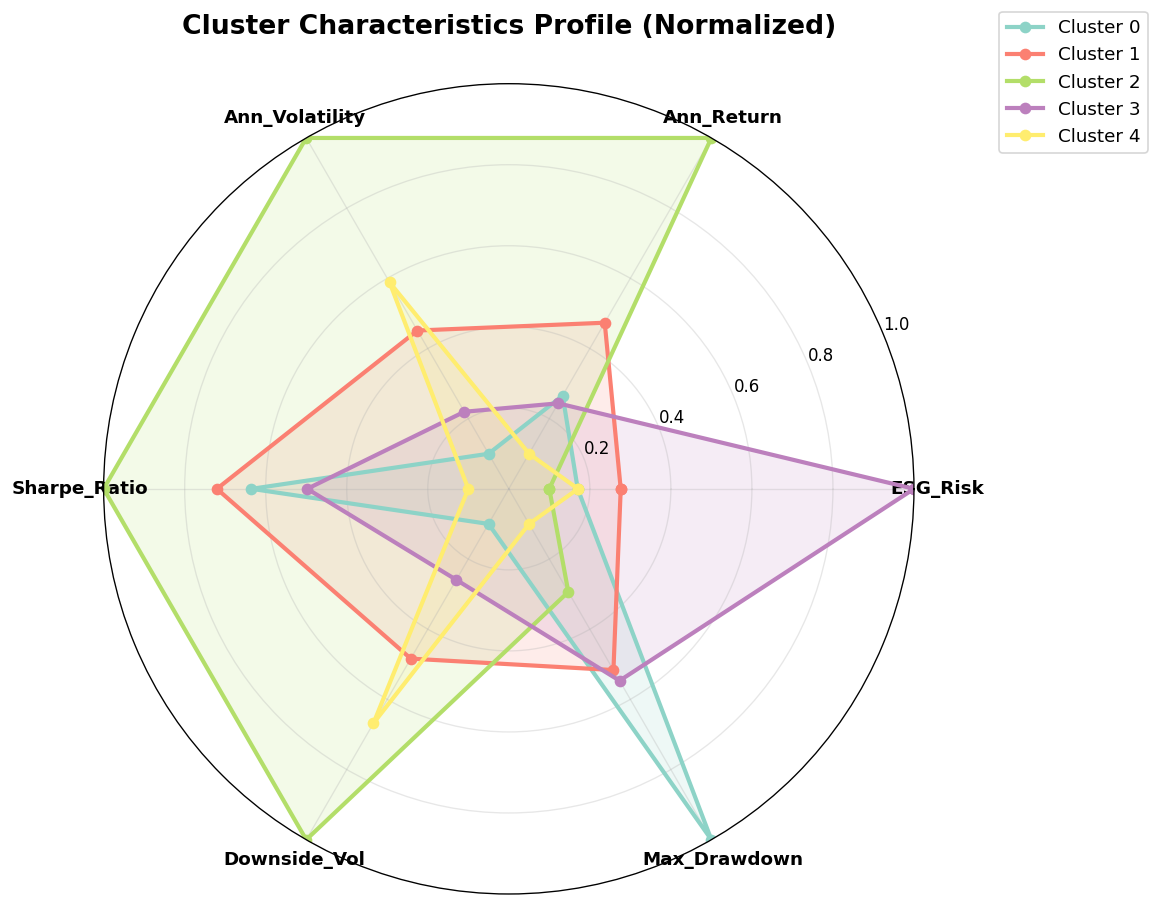

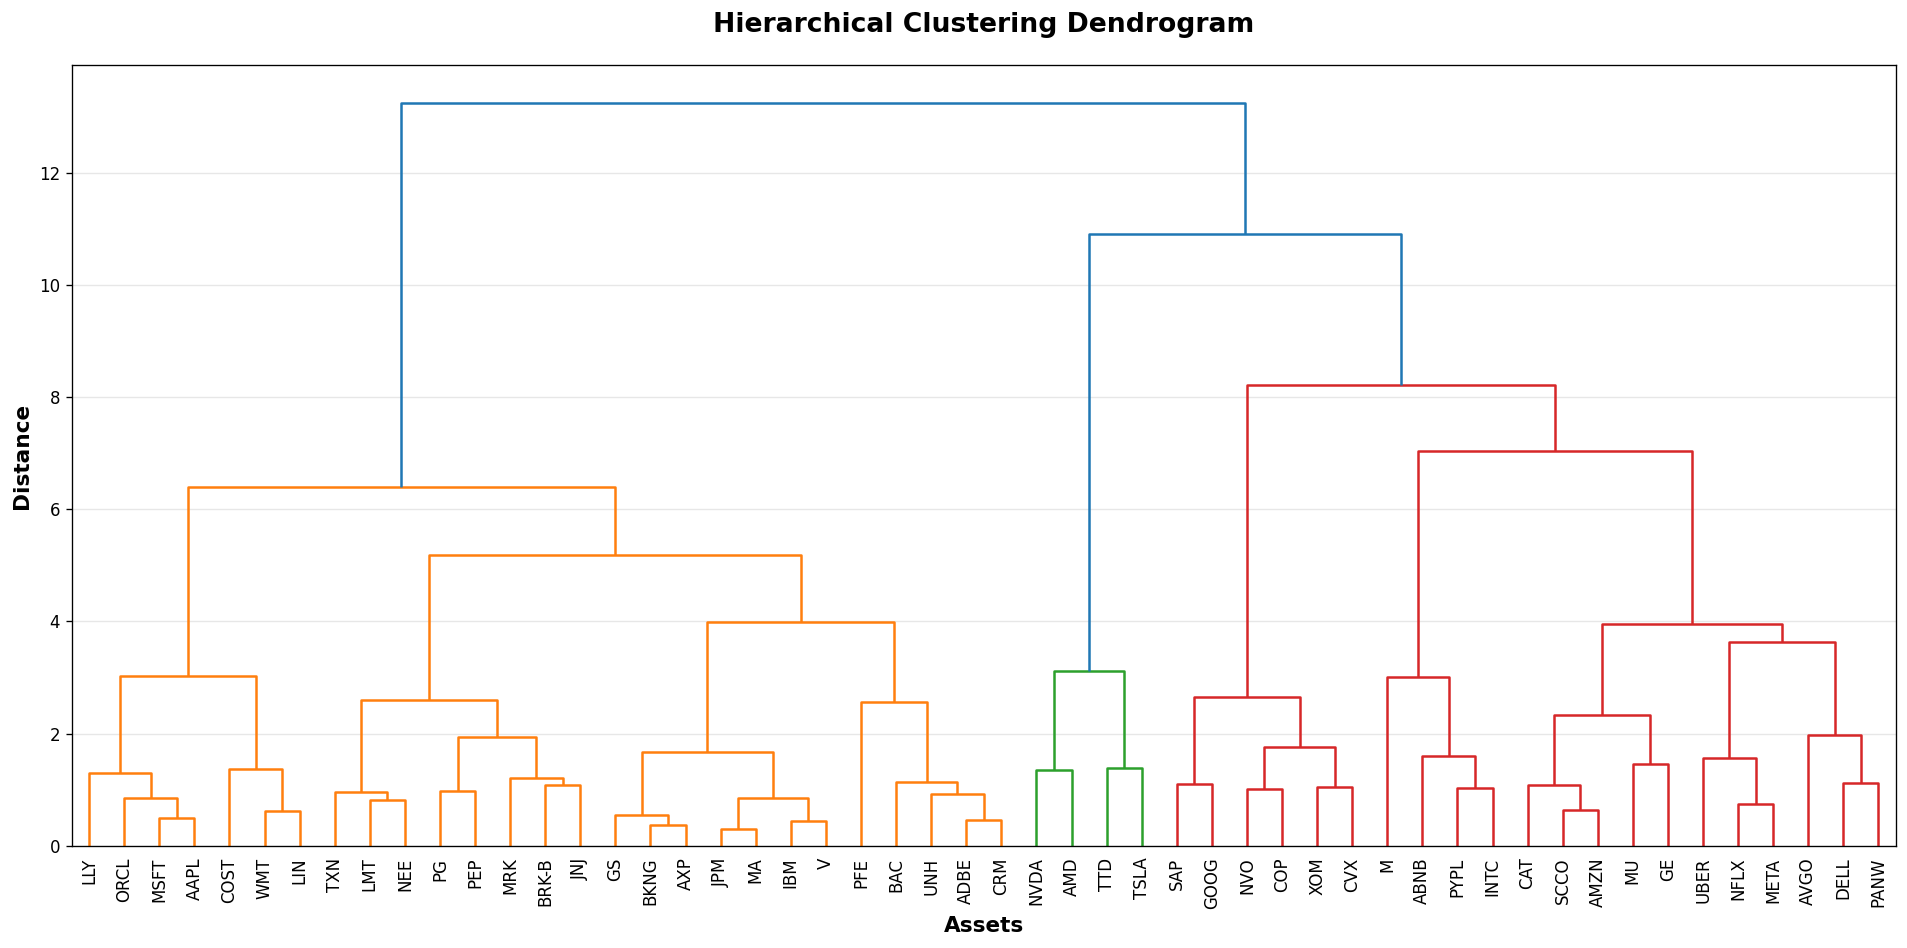

In [31]:
# Step 5: Visualize results
plot_clusters_pca(features, labels_kmeans, features.columns.tolist())
plot_cluster_characteristics(features, labels_kmeans)
plot_hierarchical_dendrogram(features_scaled, features.index)

In [32]:
# Step 6: Analyze clusters
cluster_stats = analyze_clusters(features, labels_kmeans)


CLUSTER ANALYSIS:
        ESG_Risk               Ann_Return         Ann_Volatility          \
            mean     std count       mean     std           mean     std   
Cluster                                                                    
0         4.1215  3.3132    27     0.1815  0.0732         0.2804  0.0519   
1         6.2800  4.6197    11     0.2893  0.0700         0.4058  0.0509   
2         2.6950  0.9271     4     0.5627  0.0485         0.6018  0.0879   
3        21.0033  2.2124     6     0.1700  0.0456         0.3232  0.0383   
4         4.1350  2.7342     4     0.0954  0.0536         0.4549  0.0981   

        Sharpe_Ratio          
                mean     std  
Cluster                       
0             0.6453  0.2295  
1             0.7165  0.1633  
2             0.9494  0.1591  
3             0.5306  0.1535  
4             0.1993  0.0674  


Cluster 0 (27 assets):
  Assets: BKNG, IBM, ADBE, JPM, PFE, TXN, ORCL, MSFT, AAPL, CRM, V, MA, AXP, BRK-B, BAC, GS, UNH, L

In [33]:
features_with_clusters = features.copy()
features_with_clusters['Cluster label'] = labels_kmeans
features_with_clusters.sort_values('Cluster label').style.background_gradient(subset=['Cluster label'], cmap='Set3')

In [34]:
# Step 7: Construct portfolios
weights_equal = construct_cluster_portfolio(features, labels_kmeans, Y, method='equal_weight')
weights_esg = construct_cluster_portfolio(features, labels_kmeans, Y, method='inverse_esg')
weights_sharpe = construct_cluster_portfolio(features, labels_kmeans, Y, method='sharpe_weighted')


CLUSTER-BASED PORTFOLIO (Method: equal_weight):
AMD      0.050000
M        0.050000
TTD      0.050000
NVDA     0.050000
TSLA     0.050000
INTC     0.050000
ABNB     0.050000
PYPL     0.050000
NVO      0.033333
SAP      0.033333
CVX      0.033333
COP      0.033333
GOOG     0.033333
XOM      0.033333
CAT      0.018182
GE       0.018182
META     0.018182
AMZN     0.018182
DELL     0.018182
MU       0.018182
SCCO     0.018182
PANW     0.018182
UBER     0.018182
AVGO     0.018182
NFLX     0.018182
PFE      0.007407
JNJ      0.007407
LIN      0.007407
NEE      0.007407
ORCL     0.007407
BKNG     0.007407
LMT      0.007407
TXN      0.007407
IBM      0.007407
PEP      0.007407
PG       0.007407
WMT      0.007407
COST     0.007407
MRK      0.007407
AAPL     0.007407
LLY      0.007407
MSFT     0.007407
ADBE     0.007407
GS       0.007407
BAC      0.007407
BRK-B    0.007407
AXP      0.007407
MA       0.007407
V        0.007407
CRM      0.007407
JPM      0.007407
UNH      0.007407
dtype: float64


### Each cluster gets an equal weight in the overall portfolio
But, **within** the cluster, the individual securities are weighted differently.

In [35]:
weights_equal.loc[['TTD', 'NVDA','TSLA','AMD']].sum()

0.2

In [36]:
weights_esg.loc[['TTD', 'NVDA','TSLA','AMD']].sum()

0.19999999999999998

In [37]:
weights_sharpe.loc[['TTD', 'NVDA','TSLA','AMD']].sum()

0.20000000000000004

In [38]:
# Step 8: Compare portfolios
portfolio_returns_equal = (Y @ weights_equal).squeeze()
portfolio_returns_esg = (Y @ weights_esg).squeeze()
portfolio_returns_sharpe = (Y @ weights_sharpe).squeeze()

comparison_df = pd.DataFrame({
    'Equal Weight': portfolio_returns_equal,
    'ESG Weighted': portfolio_returns_esg,
    'Sharpe Weighted': portfolio_returns_sharpe
})

print("\nPortfolio Comparison:")
print(f"Equal Weight - Return: {portfolio_returns_equal.mean()*252:.2%}, Vol: {portfolio_returns_equal.std()*np.sqrt(252):.2%}")
print(f"ESG Weighted - Return: {portfolio_returns_esg.mean()*252:.2%}, Vol: {portfolio_returns_esg.std()*np.sqrt(252):.2%}")
print(f"Sharpe Weighted - Return: {portfolio_returns_sharpe.mean()*252:.2%}, Vol: {portfolio_returns_sharpe.std()*np.sqrt(252):.2%}")


Portfolio Comparison:
Equal Weight - Return: 25.98%, Vol: 25.13%
ESG Weighted - Return: 26.48%, Vol: 25.39%
Sharpe Weighted - Return: 27.22%, Vol: 25.51%


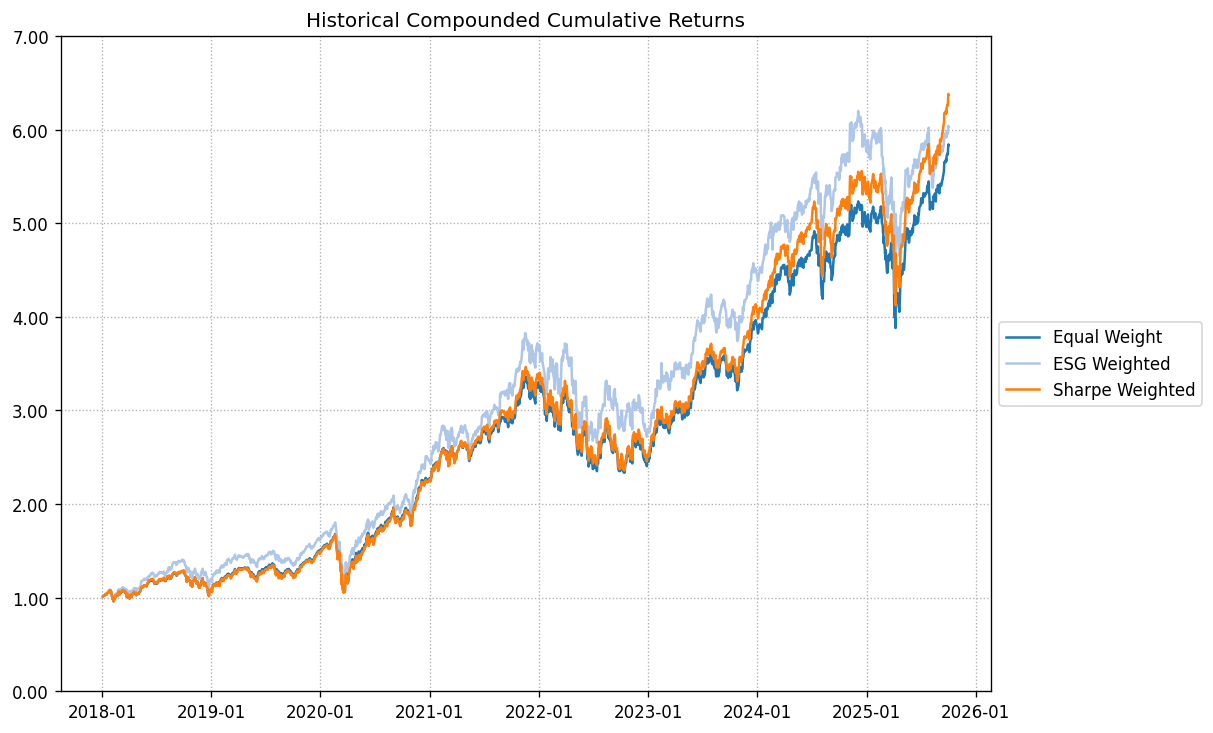

In [39]:
# Assemble weights matrix
ws = pd.concat([
    weights_equal.rename('Equal Weight'),
    weights_esg.rename('ESG Weighted'),
    weights_sharpe.rename('Sharpe Weighted')
], axis=1)

# Plot
ax = rp.plot_series(returns=Y.fillna(0),
                    w=ws,
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)
plt.show()